# Library Imports / Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [3]:
import os
import numpy as np
import random
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.0.0


In [4]:
# change current working directory
os.chdir('/content/drive/My Drive/CISC 6000: Deep Learning/Final Project (Deep Learning - Fall 2019)')
os.getcwd()

'/content/drive/My Drive/CISC 6000: Deep Learning/Final Project (Deep Learning - Fall 2019)'

In [0]:
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb, deltaE_ciede2000, deltaE_cie76
import albumentations as A
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from mpl_toolkits.axes_grid1 import ImageGrid

In [0]:
import tensorflow_datasets as tfds
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, RepeatVector, concatenate, UpSampling2D
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model, Sequence

In [0]:
# seed for randoom number generator
def seed_everything(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(SEED)
seed_everything(6000)

In [0]:
BATCH_SIZE = 100
TARGET_SIZE = (256, 256)

# Define Inception ResNet V2 Model

In [9]:
#full_inres = InceptionResNetV2(weights='imagenet', include_top=True)
#inres_model = Model(full_inres.input, full_inres.layers[-2].output) # get model without softmax layer
inres_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=TARGET_SIZE+(3,), pooling='avg')
print('INRES MODEL INPUT  SHAPE:', inres_model.input.shape)
print('INRES MODEL OUTPUT SHAPE:', inres_model.output.shape)

INRES MODEL INPUT  SHAPE: (None, 256, 256, 3)
INRES MODEL OUTPUT SHAPE: (None, 1536)


# Data Processing Functions

Notes:
take image
convert it first to lab

for l --> 2 * l / 100 - 1
for ab --> ab / 127
image embedding -- take lab -- concatenate it 3 times -- get predictions

plot:
gray scale image --> take input l component (X) and convert it to RGB grayscale
    lab = np.squeeze(255 * (img_l + 1) / 2)
    return color.gray2rgb(lab) / 255

output image (prediction) --> take l component and predicted ab component -- get one rgb image from this
    lab = np.empty([*img_l.shape[0:2], 3])
    lab[:, :, 0] = np.squeeze(((img_l + 1) * 50)) (l --> add 1 and then multiply 50 to this)
    lab[:, :, 1:] = img_ab * 127 (pred -- multiply back with 127)
    return color.lab2rgb(lab)

true image --> do same as above -- but combine l with original Y to get true image



In [0]:
def getImageArray(FOLDER_PATH, target_size=TARGET_SIZE, isColor=True, isSplit=True, test_split=0.1):
    img_files_lst = os.listdir(FOLDER_PATH)
    img_files_lst.sort()
    num_images = len(img_files_lst)
    x = []
    if isColor == True:
        color_mode = 'rgb'
    else:
        color_mode = 'grayscale'
    for img in img_files_lst:
        img_arr = img_to_array(load_img(path=FOLDER_PATH + '/' + img, target_size=target_size, color_mode=color_mode)) * 1.0/255
        x.append(img_arr)
    x = np.array(x)
    print('Finished converting', str(num_images), 'images as numpy arrays!')
    print('Image pixels are in range', x.min(), 'to', x.max())
    if isSplit == True:
        train, test = train_test_split(x, test_size=test_split)
        print('Train Shape:', train.shape)
        print('Test  Shape:', test.shape)
        return train, test
    return x

In [0]:
def getProcessedData(arr):
    arr_lab = rgb2lab(arr)
    X = 2 * arr_lab[:, :, :, 0] / 100 - 1 # scale to [-1, 1]
    X = np.expand_dims(X, axis=3)
    Y = arr_lab[:, :, :, 1:] / 128 # scale to [-1, 1]
    X_inres = np.concatenate([X, X, X], axis=3)
    X_inres = inres_model.predict(X_inres)
    print('Shape of X:', X.shape, 'with pixels in range', X.min(), 'to', X.max())
    print('Shape of X_inres:', X.shape, 'with pixels in range', X_inres.min(), 'to', X_inres.max())
    print('Shape of Y:', Y.shape, 'with pixels in range', Y.min(), 'to', Y.max())
    return X, X_inres, Y

In [0]:
class DataGenerator(Sequence):
    def __init__(self, datagen):
        self.datagen = datagen
        self.on_epoch_end()
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.datagen)
    
    def on_epoch_end(self):
        self.datagen.on_epoch_end()
    
    def __getitem__(self, idx):
        'Generates one batch of data'
        batch = self.datagen[idx]
        batch = resize(batch, output_shape=(len(batch), 256, 256, 3))
        lab_batch = rgb2lab(batch)
        X = 2 * lab_batch[:, :, :, 0] / 100 - 1 # scale to [-1, 1]
        X = np.expand_dims(X, axis=3)
        Y = lab_batch[:, :, :, 1:] / 128 # scale to [-1, 1]
        X_inres = np.concatenate([X, X, X], axis=3)
        X_inres = inres_model.predict(X_inres)
        return [X, X_inres], Y

# Model Functions

In [0]:
def conv_block(x, num_filters, kernel_size, num_strides, activation, kernel_initializer, kernel_regularizer, addBN, addDR, dRate, name):
    x = Conv2D(filters=num_filters, kernel_size=kernel_size, strides=num_strides, 
               kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer, 
               padding='same', name=name)(x)
    if addBN == True:
        x = BatchNormalization(name='bn_' + name)(x)
    if addDR == True:
        x = Dropout(dRate, name='dr_' + name)(x)
    x = Activation(activation, name='act_' + name)(x)
    return x

In [0]:
def convT_block(x, num_filters, kernel_size, num_strides, activation, kernel_initializer, kernel_regularizer, addBN, addDR, dRate, name):
    x = Conv2DTranspose(filters=num_filters, kernel_size=kernel_size, strides=num_strides, 
                        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer, 
                        padding='same', name=name)(x)
    if addBN == True:
        x = BatchNormalization(name='bn_' + name)(x)
    if addDR == True:
        x = Dropout(dRate, name='dr_' + name)(x)
    x = Activation(activation, name='act_' + name)(x)
    return x

In [0]:
def buildModel(input_shape, input_shape_inres, num_filters, kernel_size, num_layers, activation, kernel_initializer, kernel_regularizer, addBN, addDR, dRate, optimizer, loss, model_name):
    inp = Input(shape=input_shape, name='input')
    x = inp
    
    # encoder
    for i in range(num_layers):
        x = conv_block(x, num_filters=num_filters, kernel_size=kernel_size, num_strides=2,
                       activation=activation, kernel_initializer=kernel_initializer, 
                       kernel_regularizer=kernel_regularizer, addBN=addBN, addDR=addDR, dRate=dRate, 
                       name='en_stridePool_' + str(num_filters))
        num_filters = num_filters * 2
        x = conv_block(x, num_filters=num_filters, kernel_size=kernel_size, num_strides=1,
                       activation=activation, kernel_initializer=kernel_initializer, 
                       kernel_regularizer=kernel_regularizer, addBN=addBN, addDR=addDR, dRate=dRate, 
                       name='en_' + str(num_filters))
    encoder_shape = K.int_shape(x)

    # inres
    inres_inp = Input(shape=input_shape_inres, name='inres_input')
    inres_out = Dense(units=int(input_shape_inres[-1] / 3), activation=activation, 
                      kernel_initializer=kernel_initializer, name='inres_dense')(inres_inp)
    inres_out = RepeatVector(encoder_shape[1] * encoder_shape[2], name='inres_repeat')(inres_out)
    inres_out = Reshape((encoder_shape[1], encoder_shape[2], int(input_shape_inres[-1] / 3)), name='inres_reshape')(inres_out)
    inres_out = concatenate([x, inres_out], axis=3, name='inres_concat')
    num_filters = int(num_filters / 2)
    x = conv_block(inres_out, num_filters=num_filters, kernel_size=1, num_strides=1,
                   activation=activation, kernel_initializer=kernel_initializer, 
                   kernel_regularizer=kernel_regularizer, addBN=addBN, addDR=addDR, dRate=dRate, 
                   name='inres_conv' + str(num_filters))
    
    # decoder
    for i in range(num_layers):
        num_filters = int(num_filters / 2)
        x = conv_block(x, num_filters=num_filters, kernel_size=kernel_size, num_strides=1,
                       activation=activation, kernel_initializer=kernel_initializer, 
                       kernel_regularizer=kernel_regularizer, addBN=addBN, addDR=addDR, dRate=dRate, 
                        name='de_' + str(num_filters))
        x = UpSampling2D(name='de_upsample' + str(num_filters))(x)
    
    out = conv_block(x, num_filters=2, kernel_size=kernel_size, num_strides=1,
                     activation='tanh', kernel_initializer=kernel_initializer, 
                     kernel_regularizer=kernel_regularizer, addBN=False, addDR=False, dRate=0.0, 
                     name='output')
    
    model = Model([inp, inres_inp], out, name=model_name)
    model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])
    return model

In [0]:
def fit(model, epochs, train_gen, val_gen, verbose, callbacks_list):
    start = time.time()
    history = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(train_gen), verbose=verbose, 
                                  validation_data=val_gen, validation_steps=len(val_gen), callbacks=callbacks_list)
    end = time.time() - start
    print('\n\tTotal Training Time:', np.round(end, 2), 'seconds')
    print('Train Loss:', np.round(np.mean(history.history['loss']), 4), 
          '\tMAE:', np.round(np.mean(history.history['mae']), 4))
    print('Val   Loss:', np.round(np.mean(history.history['val_loss']), 4), 
          '\tMAE:', np.round(np.mean(history.history['val_mae']), 4))
    return history, model

# Evaluation Functions

In [0]:
def plotHistory(history):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'r--', label='train_loss')
    plt.plot(history.history['val_loss'], 'b-', label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Learning Curve')
    plt.legend(loc='best')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], 'r--', label='train_mae')
    plt.plot(history.history['val_mae'], 'b-', label='val_mae')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('MAE Learning Curve')
    plt.legend(loc='best')
    plt.show()

In [0]:
def predict(model, X, X_inres, Y):
    eval_results = model.evaluate([X, X_inres], Y, verbose=0)
    print('Test  Loss:', np.round(eval_results[0], 4), '\tMAE:', np.round(eval_results[1], 4))
    pred = model.predict([X, X_inres])
    canvas = np.zeros(X.shape[:-1]+(3,))
    canvas[:, :, :, 0] = (X[:, :, :, 0] + 1) * 50
    canvas[:, :, :, 1:] = pred * 128
    return canvas

In [0]:
def getSSIM(true, pred):
    return np.mean(tf.image.ssim(tf.convert_to_tensor(true, dtype='float32'), 
                                 tf.convert_to_tensor(pred, dtype='float32'), 
                                 max_val=1.0))

In [0]:
def plotResult(true, pred_arr_list, pred_label_list, num_imgs):
    for i in range(num_imgs):
        plt.figure(figsize=(20, 20))
        plt.subplot(1, len(pred_arr_list) + 2, 1)
        plt.imshow(rgb2gray(true[i]), cmap='gray')
        plt.axis('off')
        plt.title('Grayscale')
        for j in range(len(pred_arr_list)):
            plt.subplot(1, len(pred_arr_list) + 2, j+2)
            plt.imshow(lab2rgb(pred_arr_list[j][i]))
            plt.axis('off')
            plt.title(pred_label_list[j])
        plt.subplot(1, len(pred_arr_list) + 2, len(pred_arr_list) + 2)
        plt.imshow(true[i])
        plt.axis('off')
        plt.title('Ground Truth')
        plt.show()

# Baseline (Train Numpy - Nature)

In [0]:
def getTrainValBatch(generator, generator_inres):
    for batch, batch_inres in zip(generator, generator_inres):
        # process normal lab batch
        batch = batch * 1.0/255
        lab_batch = rgb2lab(batch)
        X = lab_batch[:, :, :, 0] / 100
        X = np.expand_dims(X, axis=3)
        Y = lab_batch[:, :, :, 1:] / 128
        # process inres batch
        X_inres = np.expand_dims(rgb2gray(batch_inres), axis=3)
        X_inres = np.concatenate([X_inres, X_inres, X_inres], axis=3)
        X_inres = preprocess_input(X_inres)
        X_inres = inres_model.predict(X_inres)
        X_inres = X_inres / np.max(X_inres)
        yield ([X, X_inres], Y)

In [0]:
BATCH_SIZE = 32
TARGET_SIZE = (256, 256)
TARGET_SIZE_INRES = (299, 299)
VAL_SPLIT = 0.131

In [0]:
imageGenerator = ImageDataGenerator(data_format='channels_last', validation_split=VAL_SPLIT, 
                                    shear_range=0.2, zoom_range=0.2, rotation_range=40,
                                    width_shift_range=0.2, height_shift_range=0.2, 
                                    horizontal_flip=True, vertical_flip=True)

print('\t\t\tTrain and Val Generator (CONV MODEL)')
train_gen = imageGenerator.flow_from_directory(directory='./DATA/Nature', subset='training', classes=['train'], 
                                               class_mode=None, target_size=TARGET_SIZE, batch_size=BATCH_SIZE)
val_gen = imageGenerator.flow_from_directory(directory='./DATA/Nature', subset='validation', classes=['train'], 
                                             class_mode=None, target_size=TARGET_SIZE, batch_size=BATCH_SIZE)

print('\n\t\t\tTrain and Val Generator (INRES MODEL)')
train_gen_inres = imageGenerator.flow_from_directory(directory='./DATA/Nature', subset='training', classes=['train'], 
                                                     class_mode=None, target_size=TARGET_SIZE_INRES, batch_size=BATCH_SIZE)
val_gen_inres = imageGenerator.flow_from_directory(directory='./DATA/Nature', subset='validation', classes=['train'], 
                                                   class_mode=None, target_size=TARGET_SIZE_INRES, batch_size=BATCH_SIZE)

			Train and Val Generator (CONV MODEL)
Found 200 images belonging to 1 classes.
Found 30 images belonging to 1 classes.

			Train and Val Generator (INRES MODEL)
Found 200 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


In [0]:
train = getImageArray(FOLDER_PATH='./DATA/Nature/train', target_size=TARGET_SIZE, isColor=True)
train = train * 1.0/255

train_inres = getImageArray(FOLDER_PATH='./DATA/Nature/train', target_size=TARGET_SIZE_INRES, isColor=False)
train_inres = np.concatenate([train_inres, train_inres, train_inres], axis=3)
train_inres = preprocess_input(train_inres)
train_inres = inres_model.predict(train_inres)
train_inres = train_inres/np.max(train_inres)

train_lab = rgb2lab(train)
train_X = train_lab[:, :, :, 0] / 100
train_X = train_X.reshape(train_X.shape+(1,))
train_Y = train_lab[:, :, :, 1:] / 128

print('\nShape of TRAIN:      ', train.shape, 'with pixels in range', train.min(), 'to', train.max())
print('Shape of TRAIN INRES:', train_inres.shape, 'with pixels in range', train_inres.min(), 'to', train_inres.max())
print('Shape of TRAIN LAB:  ', train_lab.shape, 'with pixels in range', train_lab.min(), 'to', train_lab.max())
print('Shape of TRAIN X:    ', train_X.shape, 'with pixels in range', train_X.min(), 'to', train_X.max())
print('Shape of TRAIN Y:    ', train_Y.shape, 'with pixels in range', train_Y.min(), 'to', train_Y.max())

Finished converting 230 images as numpy arrays!
Finished converting 230 images as numpy arrays!

Shape of TRAIN:       (230, 256, 256, 3) with pixels in range 0.0 to 1.0
Shape of TRAIN INRES: (230, 1536) with pixels in range 0.0 to 1.0
Shape of TRAIN LAB:   (230, 256, 256, 3) with pixels in range -72.04820685313138 to 100.0
Shape of TRAIN X:     (230, 256, 256, 1) with pixels in range 0.0 to 1.0
Shape of TRAIN Y:     (230, 256, 256, 2) with pixels in range -0.5628766160400889 to 0.7186568026816064


In [0]:
# load test data as numpy
test = getImageArray(FOLDER_PATH='./DATA/Nature/test', target_size=TARGET_SIZE, isColor=True)
test = test * 1.0/255

test_inres = getImageArray(FOLDER_PATH='./DATA/Nature/test', target_size=TARGET_SIZE_INRES, isColor=False)
test_inres = np.concatenate([test_inres, test_inres, test_inres], axis=3)
test_inres = preprocess_input(test_inres)
test_inres = inres_model.predict(test_inres)
test_inres = test_inres/np.max(test_inres)

test_lab = rgb2lab(test)
test_X = test_lab[:, :, :, 0] / 100
test_X = test_X.reshape(test_X.shape+(1,))
test_Y = test_lab[:, :, :, 1:] / 128

print('\nShape of TEST:      ', test.shape, 'with pixels in range', test.min(), 'to', test.max())
print('Shape of TEST INRES:', test_inres.shape, 'with pixels in range', test_inres.min(), 'to', test_inres.max())
print('Shape of TEST LAB:  ', test_lab.shape, 'with pixels in range', test_lab.min(), 'to', test_lab.max())
print('Shape of TEST X:    ', test_X.shape, 'with pixels in range', test_X.min(), 'to', test_X.max())
print('Shape of TEST Y:    ', test_Y.shape, 'with pixels in range', test_Y.min(), 'to', test_Y.max())

Finished converting 28 images as numpy arrays!
Finished converting 28 images as numpy arrays!

Shape of TEST:       (28, 256, 256, 3) with pixels in range 0.0 to 1.0
Shape of TEST INRES: (28, 1536) with pixels in range 0.0 to 1.0
Shape of TEST LAB:   (28, 256, 256, 3) with pixels in range -68.54451648361746 to 100.0
Shape of TEST X:     (28, 256, 256, 1) with pixels in range 0.0 to 1.0
Shape of TEST Y:     (28, 256, 256, 2) with pixels in range -0.5355040350282614 to 0.7049303007887889


In [0]:
base_l2 = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                     num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                     kernel_initializer='glorot_uniform', kernel_regularizer=None, 
                     addBN=False, optimizer='adam', loss='mse', model_name='base_l2')
base_l2.summary()

Model: "base_l2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
en_stridePool_64 (Conv2D)       (None, 128, 128, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
act_en_stridePool_64 (Activatio (None, 128, 128, 64) 0           en_stridePool_64[0][0]           
__________________________________________________________________________________________________
en_128 (Conv2D)                 (None, 128, 128, 128 73856       act_en_stridePool_64[0][0]       
____________________________________________________________________________________________

Train on 230 samples
Epoch 1/500
230/230 [==============================] - 3s 14ms/sample - loss: 0.0258
Epoch 2/500
230/230 [==============================] - 2s 7ms/sample - loss: 0.0223
Epoch 3/500
230/230 [==============================] - 2s 7ms/sample - loss: 0.0218
Epoch 4/500
230/230 [==============================] - 2s 7ms/sample - loss: 0.0207
Epoch 5/500
230/230 [==============================] - 2s 7ms/sample - loss: 0.0202
Epoch 6/500
230/230 [==============================] - 2s 7ms/sample - loss: 0.0198
Epoch 7/500
230/230 [==============================] - 2s 7ms/sample - loss: 0.0184
Epoch 8/500
230/230 [==============================] - 2s 7ms/sample - loss: 0.0179
Epoch 9/500
230/230 [==============================] - 2s 7ms/sample - loss: 0.0177
Epoch 10/500
230/230 [==============================] - 2s 7ms/sample - loss: 0.0177
Epoch 11/500
230/230 [==============================] - 2s 7ms/sample - loss: 0.0169
Epoch 12/500
230/230 [==============================

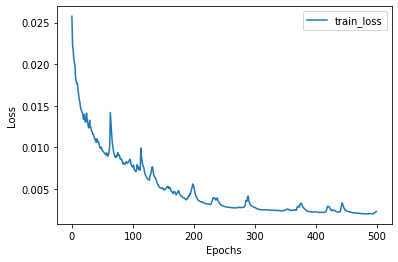

In [0]:
history_base_l2 = base_l2.fit([train_X, train_inres], train_Y, epochs=500, batch_size=32)
plotHistory(base_l2)

In [0]:
pred_base_l2 = predict(model=base_l2, X_inres=test_inres, X=test_X, Y=test_Y)
plotResult(true=test, pred_arr_list=[pred_base_l2], pred_label_list=['Base-L2'], num_imgs=len(test))

Output hidden; open in https://colab.research.google.com to view.

# BatchNorm Models with L2, L1 and Huber Loss

In [0]:
BATCH_SIZE = 32
TARGET_SIZE = (256, 256)

In [0]:
l2 = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                kernel_initializer='he_normal', kernel_regularizer=None, 
                addBN=True, optimizer='adam', loss='mse', model_name='l2')
l2.summary()

Model: "l2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
en_stridePool_64 (Conv2D)       (None, 128, 128, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
bn_en_stridePool_64 (BatchNorma (None, 128, 128, 64) 256         en_stridePool_64[0][0]           
__________________________________________________________________________________________________
act_en_stridePool_64 (Activatio (None, 128, 128, 64) 0           bn_en_stridePool_64[0][0]        
_________________________________________________________________________________________________

In [0]:
l1 = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                kernel_initializer='he_normal', kernel_regularizer=None, 
                addBN=True, optimizer='adam', loss='mae', model_name='l1')

In [0]:
huber = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                kernel_initializer='he_normal', kernel_regularizer=None, 
                addBN=True, optimizer='adam', loss='huber_loss', model_name='huber')

# Train + Val Datagenerator + BatchNorm - Nature (No Data Augmentation)

In [0]:
train, val, test = getImageArray(FOLDER_PATH='./DATA/Nature-Full', target_size=TARGET_SIZE, isColor=True, isSplit=True)

Finished converting 258 images as numpy arrays!
Train Shape: (208, 256, 256, 3)
Val   Shape: (24, 256, 256, 3)
Test  Shape: (26, 256, 256, 3)


In [0]:
train_generator = DataGenerator(img_arr=train, batch_size=BATCH_SIZE, isInres=True)
val_generator = DataGenerator(img_arr=val, batch_size=BATCH_SIZE, isInres=True)

In [0]:
test_lab = rgb2lab(test * 1.0/255)
test_X = test_lab[:, :, :, 0] / 100
test_X = np.expand_dims(test_X, axis=3)
test_Y = test_lab[:, :, :, 1:] / 128

test_inres = np.array([resize(img, (299, 299)) for img in test])
test_inres = np.expand_dims(rgb2gray(test_inres), axis=3)
test_inres = np.concatenate([test_inres, test_inres, test_inres], axis=3)
test_inres = preprocess_input(test_inres)
test_inres = inres_model.predict(test_inres)
test_inres = test_inres/np.max(test_inres)

print('\nShape of TEST:      ', test.shape, 'with pixels in range', test.min(), 'to', test.max())
print('Shape of TEST INRES:', test_inres.shape, 'with pixels in range', test_inres.min(), 'to', test_inres.max())
print('Shape of TEST LAB:  ', test_lab.shape, 'with pixels in range', test_lab.min(), 'to', test_lab.max())
print('Shape of TEST X:    ', test_X.shape, 'with pixels in range', test_X.min(), 'to', test_X.max())
print('Shape of TEST Y:    ', test_Y.shape, 'with pixels in range', test_Y.min(), 'to', test_Y.max())


Shape of TEST:       (26, 256, 256, 3) with pixels in range 0.0 to 255.0
Shape of TEST INRES: (26, 1536) with pixels in range 0.0 to 1.0
Shape of TEST LAB:   (26, 256, 256, 3) with pixels in range -68.54451648361746 to 100.0
Shape of TEST X:     (26, 256, 256, 1) with pixels in range 0.0 to 1.0
Shape of TEST Y:     (26, 256, 256, 2) with pixels in range -0.5355040350282614 to 0.6891341181747062


## With Early Stopping (Patience = 10)

Epoch 00060: early stopping

	Total Training Time: 648.33 seconds
Train Loss: 0.0169 	Accuracy: 0.7344
Val   Loss: 0.1186 	Accuracy: 0.6647


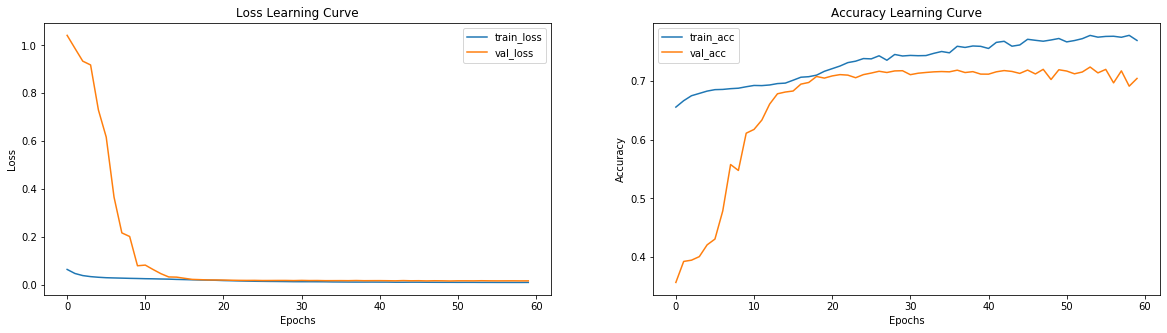

In [0]:
history, l2 = fit(model=l2, epochs=500, train_gen=train_generator, val_gen=val_generator, verbose=0, 
                  callbacks_list=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])
plotHistory(history)

Epoch 00056: early stopping

	Total Training Time: 607.34 seconds
Train Loss: 0.0836 	Accuracy: 0.7317
Val   Loss: 0.185 	Accuracy: 0.6479


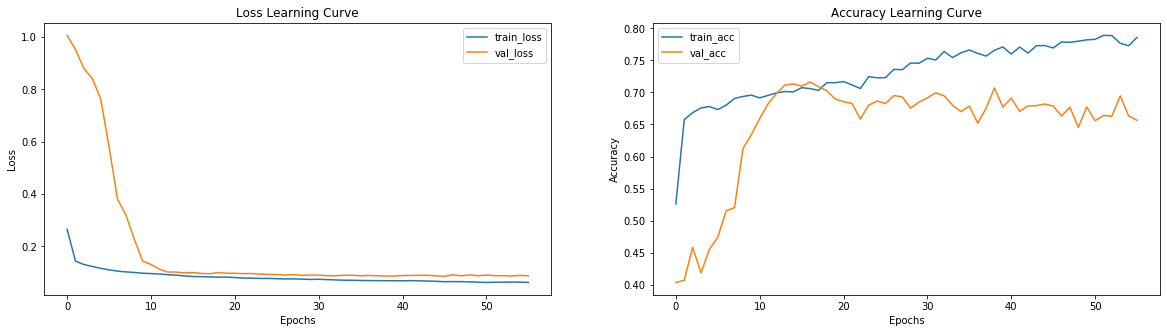

In [0]:
history, l1 = fit(model=l1, epochs=500, train_gen=train_generator, val_gen=val_generator, verbose=0, 
                  callbacks_list=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])
plotHistory(history)

Epoch 00062: early stopping

	Total Training Time: 665.58 seconds
Train Loss: 0.0086 	Accuracy: 0.7288
Val   Loss: 0.0603 	Accuracy: 0.6513


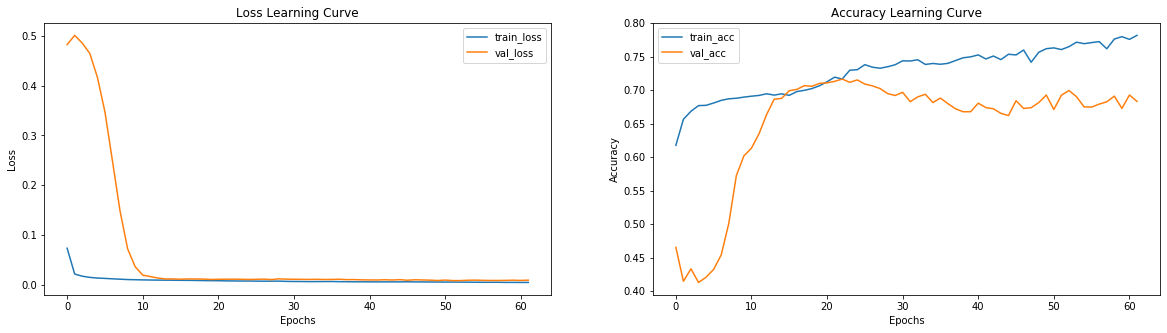

In [0]:
history, huber = fit(model=huber, epochs=500, train_gen=train_generator, val_gen=val_generator, verbose=0, 
                     callbacks_list=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])
plotHistory(history)

In [0]:
pred_l2 = predict(model=l2, X_inres=test_inres, X=test_X, Y=test_Y)
pred_l1 = predict(model=l1, X_inres=test_inres, X=test_X, Y=test_Y)
pred_huber = predict(model=huber, X_inres=test_inres, X=test_X, Y=test_Y)

Loss: 0.0158 	Accuracy: 0.7429
Loss: 0.0872 	Accuracy: 0.7179
Loss: 0.0088 	Accuracy: 0.7609


In [0]:
plotResult(true=test, pred_arr_list=[pred_l2, pred_l1, pred_huber], pred_label_list=['L2', 'L1', 'Huber'], num_imgs=len(test))

Output hidden; open in https://colab.research.google.com to view.

## Without Early Stopping (500 Epochs)


	Total Training Time: 5277.3 seconds
Train Loss: 0.0038 	Accuracy: 0.8399
Val   Loss: 0.0164 	Accuracy: 0.6943


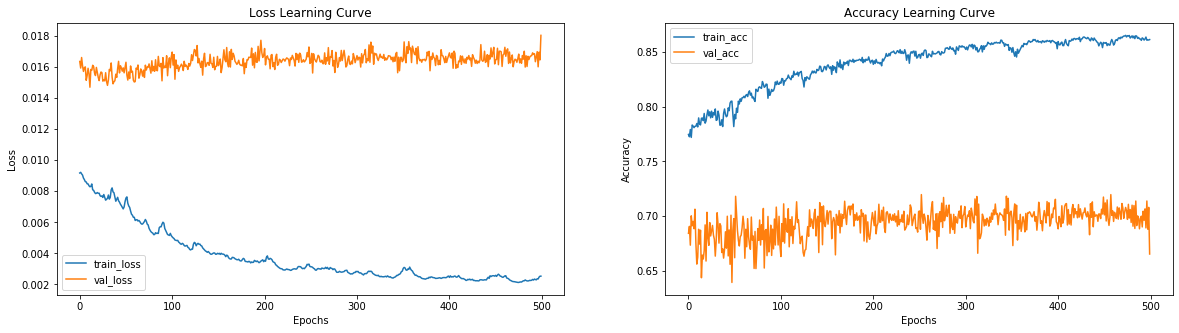

In [0]:
history, l2 = fit(model=l2, epochs=500, train_gen=train_generator, val_gen=val_generator, verbose=0, callbacks_list=None)
plotHistory(history)


	Total Training Time: 5254.67 seconds
Train Loss: 0.0389 	Accuracy: 0.8523
Val   Loss: 0.084 	Accuracy: 0.709


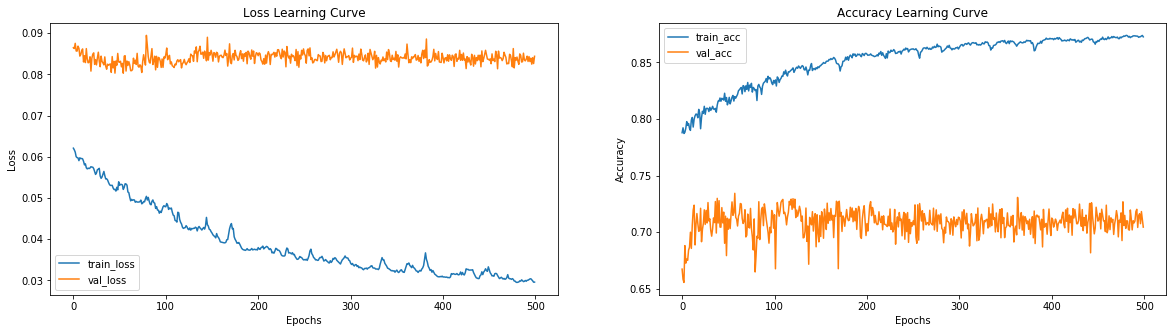

In [0]:
history, l1 = fit(model=l1, epochs=500, train_gen=train_generator, val_gen=val_generator, verbose=0, callbacks_list=None)
plotHistory(history)

In [0]:
pred_l2 = predict(model=l2, X_inres=test_inres, X=test_X, Y=test_Y)
pred_l1 = predict(model=l1, X_inres=test_inres, X=test_X, Y=test_Y)

Loss: 0.0167 	Accuracy: 0.718
Loss: 0.0845 	Accuracy: 0.742


In [0]:
plotResult(true=test, pred_arr_list=[pred_l2, pred_l1], pred_label_list=['L2', 'L1'], num_imgs=len(test))

Output hidden; open in https://colab.research.google.com to view.

# Data Augmentation Trial

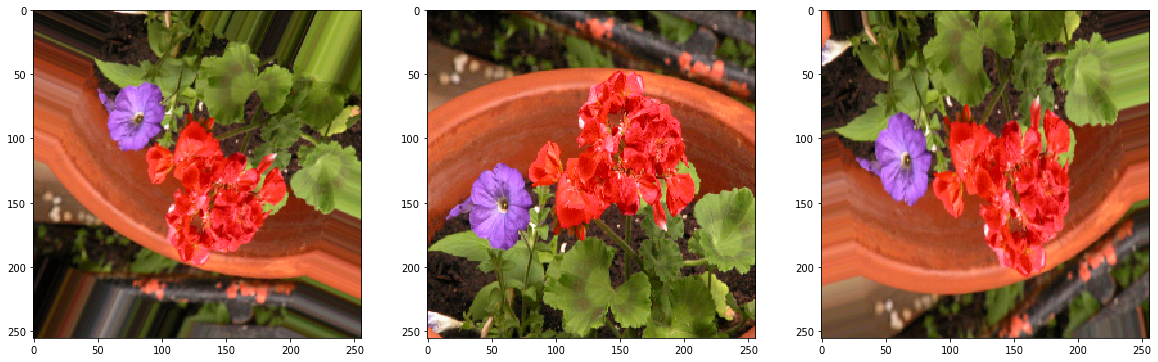

In [0]:
d = ImageDataGenerator(data_format='channels_last', zoom_range=0.2, rotation_range=40, horizontal_flip=True, vertical_flip=True)
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(d.apply_transform(test[0]*1.0/255, d.get_random_transform((256, 256, 3))))
plt.subplot(1, 3, 2)
plt.imshow(test[0] * 1.0/255)
plt.subplot(1, 3, 3)
plt.imshow(d.random_transform(test[0]*1.0/255))
plt.show()

# Models with Dropout + BatchNorm - L2 Loss (default Adam parameters)

In [0]:
BATCH_SIZE = 32
TARGET_SIZE = (256, 256)

In [0]:
l2_01 = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],),
                   num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                   kernel_initializer='he_normal', kernel_regularizer=None, 
                   addBN=True, addDR=True, dRate=0.1, optimizer='adam', loss='mse', model_name='l2_01')
l2_01.summary()

Model: "l2_01"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
en_stridePool_64 (Conv2D)       (None, 128, 128, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
bn_en_stridePool_64 (BatchNorma (None, 128, 128, 64) 256         en_stridePool_64[0][0]           
__________________________________________________________________________________________________
dr_en_stridePool_64 (Dropout)   (None, 128, 128, 64) 0           bn_en_stridePool_64[0][0]        
______________________________________________________________________________________________

In [0]:
l2_03 = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],),
                   num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                   kernel_initializer='he_normal', kernel_regularizer=None, 
                   addBN=True, addDR=True, dRate=0.3, optimizer='adam', loss='mse', model_name='l2_03')

In [0]:
l2_05 = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],),
                   num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                   kernel_initializer='he_normal', kernel_regularizer=None, 
                   addBN=True, addDR=True, dRate=0.5, optimizer='adam', loss='mse', model_name='l2_05')

# Dropout + BatchNorm Experiments

## Nature (FULL)

In [0]:
BATCH_SIZE = 32
TARGET_SIZE = (256, 256)

In [0]:
train, val, test = getImageArray(FOLDER_PATH='./DATA/Nature-Full', target_size=TARGET_SIZE, isColor=True, isSplit=True)

Finished converting 258 images as numpy arrays!
Train Shape: (208, 256, 256, 3)
Val   Shape: (24, 256, 256, 3)
Test  Shape: (26, 256, 256, 3)


In [0]:
train_generator = DataGenerator(img_arr=train, batch_size=BATCH_SIZE, isInres=True)
val_generator = DataGenerator(img_arr=val, batch_size=BATCH_SIZE, isInres=True)

In [0]:
test_lab = rgb2lab(test * 1.0/255)
test_X = test_lab[:, :, :, 0] / 100
test_X = np.expand_dims(test_X, axis=3)
test_Y = test_lab[:, :, :, 1:] / 128

test_inres = np.array([resize(img, (299, 299)) for img in test])
test_inres = np.expand_dims(rgb2gray(test_inres), axis=3)
test_inres = np.concatenate([test_inres, test_inres, test_inres], axis=3)
test_inres = preprocess_input(test_inres)
test_inres = inres_model.predict(test_inres)
test_inres = test_inres/np.max(test_inres)

print('\nShape of TEST:      ', test.shape, 'with pixels in range', test.min(), 'to', test.max())
print('Shape of TEST INRES:', test_inres.shape, 'with pixels in range', test_inres.min(), 'to', test_inres.max())
print('Shape of TEST LAB:  ', test_lab.shape, 'with pixels in range', test_lab.min(), 'to', test_lab.max())
print('Shape of TEST X:    ', test_X.shape, 'with pixels in range', test_X.min(), 'to', test_X.max())
print('Shape of TEST Y:    ', test_Y.shape, 'with pixels in range', test_Y.min(), 'to', test_Y.max())


Shape of TEST:       (26, 256, 256, 3) with pixels in range 0.0 to 255.0
Shape of TEST INRES: (26, 1536) with pixels in range 0.0 to 1.0
Shape of TEST LAB:   (26, 256, 256, 3) with pixels in range -68.54451648361746 to 100.0
Shape of TEST X:     (26, 256, 256, 1) with pixels in range 0.0 to 1.0
Shape of TEST Y:     (26, 256, 256, 2) with pixels in range -0.5355040350282614 to 0.6891341181747062



	Total Training Time: 873.78 seconds
Train Loss: 0.0156 	Accuracy: 0.7477
Val   Loss: 0.0753 	Accuracy: 0.691


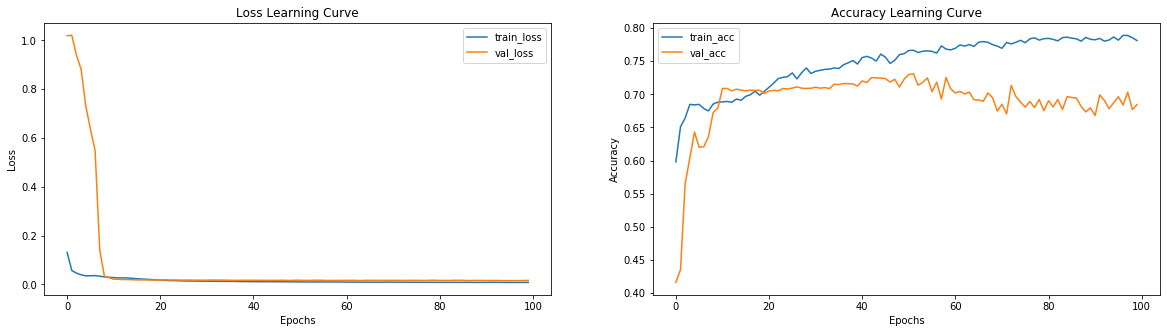

In [0]:
history, l2_01 = fit(model=l2_01, epochs=100, train_gen=train_generator, val_gen=val_generator, verbose=0, callbacks_list=None)
plotHistory(history)


	Total Training Time: 865.1 seconds
Train Loss: 0.0243 	Accuracy: 0.7121
Val   Loss: 0.076 	Accuracy: 0.6931


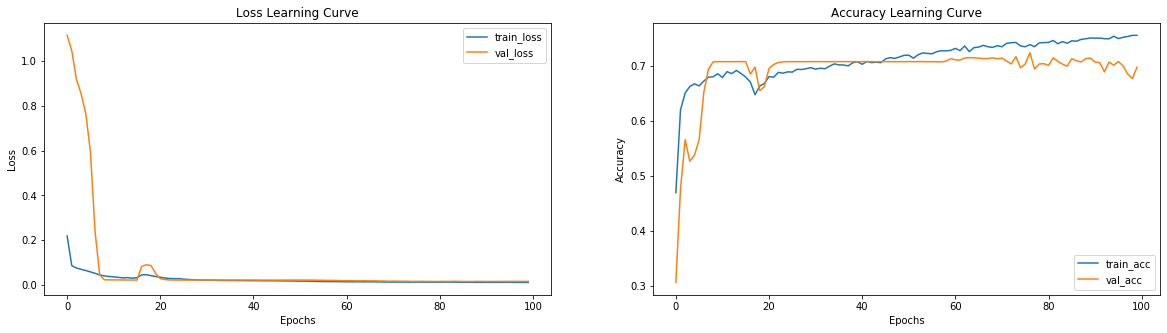

In [0]:
history, l2_03 = fit(model=l2_03, epochs=100, train_gen=train_generator, val_gen=val_generator, verbose=0, callbacks_list=None)
plotHistory(history)


	Total Training Time: 857.63 seconds
Train Loss: 0.0281 	Accuracy: 0.6918
Val   Loss: 0.105 	Accuracy: 0.6848


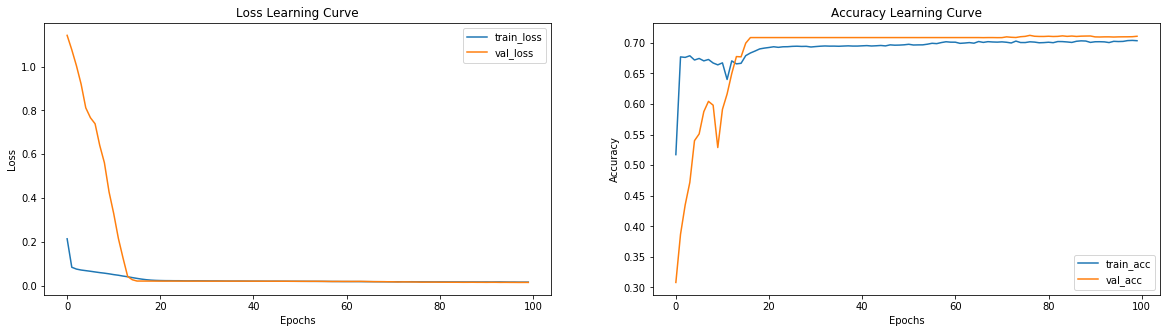

In [0]:
history, l2_05 = fit(model=l2_05, epochs=100, train_gen=train_generator, val_gen=val_generator, verbose=0, callbacks_list=None)
plotHistory(history)

In [0]:
print('\tL2 with Dropout 0.1')
pred_l2_01 = predict(model=l2_01, X_inres=test_inres, X=test_X, Y=test_Y)
print('\tL2 with Dropout 0.3')
pred_l2_03 = predict(model=l2_03, X_inres=test_inres, X=test_X, Y=test_Y)
print('\tL2 with Dropout 0.5')
pred_l2_05 = predict(model=l2_05, X_inres=test_inres, X=test_X, Y=test_Y)

	L2 with Dropout 0.1
Loss: 0.016 	Accuracy: 0.7599
	L2 with Dropout 0.3
Loss: 0.0159 	Accuracy: 0.752
	L2 with Dropout 0.5
Loss: 0.017 	Accuracy: 0.6907


In [0]:
plotResult(true=test, pred_arr_list=[pred_l2_01, pred_l2_03, pred_l2_05], 
           pred_label_list=['L2 (DR = 0.1)', 'L2 (DR = 0.3)', 'L2 (DR = 0.5)'], 
           num_imgs=len(test))

Output hidden; open in https://colab.research.google.com to view.

## Man Made

In [0]:
BATCH_SIZE = 32
TARGET_SIZE = (256, 256)

In [0]:
train, val, test = getImageArray(FOLDER_PATH='./DATA/ManMade', target_size=TARGET_SIZE, isColor=True, isSplit=True)

Finished converting 419 images as numpy arrays!
Train Shape: (339, 256, 256, 3)
Val   Shape: (38, 256, 256, 3)
Test  Shape: (42, 256, 256, 3)


In [0]:
train_generator = DataGenerator(img_arr=train, batch_size=BATCH_SIZE, isInres=True)
val_generator = DataGenerator(img_arr=val, batch_size=BATCH_SIZE, isInres=True)

In [0]:
test_lab = rgb2lab(test * 1.0/255)
test_X = test_lab[:, :, :, 0] / 100
test_X = np.expand_dims(test_X, axis=3)
test_Y = test_lab[:, :, :, 1:] / 128

test_inres = np.array([resize(img, (299, 299)) for img in test])
test_inres = np.expand_dims(rgb2gray(test_inres), axis=3)
test_inres = np.concatenate([test_inres, test_inres, test_inres], axis=3)
test_inres = preprocess_input(test_inres)
test_inres = inres_model.predict(test_inres)
test_inres = test_inres/np.max(test_inres)

print('\nShape of TEST:      ', test.shape, 'with pixels in range', test.min(), 'to', test.max())
print('Shape of TEST INRES:', test_inres.shape, 'with pixels in range', test_inres.min(), 'to', test_inres.max())
print('Shape of TEST LAB:  ', test_lab.shape, 'with pixels in range', test_lab.min(), 'to', test_lab.max())
print('Shape of TEST X:    ', test_X.shape, 'with pixels in range', test_X.min(), 'to', test_X.max())
print('Shape of TEST Y:    ', test_Y.shape, 'with pixels in range', test_Y.min(), 'to', test_Y.max())


Shape of TEST:       (42, 256, 256, 3) with pixels in range 0.0 to 255.0
Shape of TEST INRES: (42, 1536) with pixels in range 0.0 to 1.0
Shape of TEST LAB:   (42, 256, 256, 3) with pixels in range -67.0145442260695 to 100.0
Shape of TEST X:     (42, 256, 256, 1) with pixels in range 0.0 to 1.0
Shape of TEST Y:     (42, 256, 256, 2) with pixels in range -0.523551126766168 to 0.6544932526896222


### Dropout = 0.3 (100, 300, 500 epochs)


	Total Training Time: 1376.46 seconds
Train Loss: 0.0062 	Accuracy: 0.6652
Val   Loss: 0.0091 	Accuracy: 0.6598


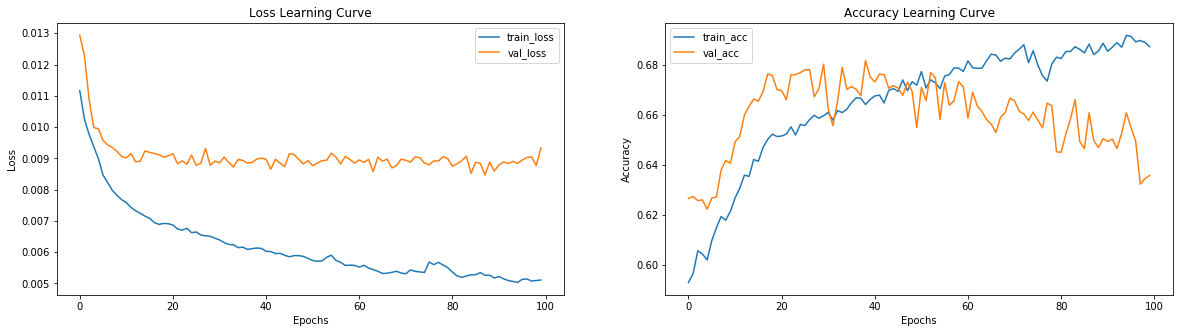

Loss: 0.0091 	Accuracy: 0.632


In [0]:
history, l2_03 = fit(model=l2_03, epochs=100, train_gen=train_generator, val_gen=val_generator, verbose=0, callbacks_list=None)
plotHistory(history)
pred_l2_03_100 = predict(model=l2_03, X_inres=test_inres, X=test_X, Y=test_Y)

In [0]:
plotResult(true=test, pred_arr_list=[pred_l2_03_100], pred_label_list=['L2, DR = 0.3, 100'], num_imgs=len(test))

Output hidden; open in https://colab.research.google.com to view.


	Total Training Time: 4143.39 seconds
Train Loss: 0.0041 	Accuracy: 0.7125
Val   Loss: 0.0085 	Accuracy: 0.6509


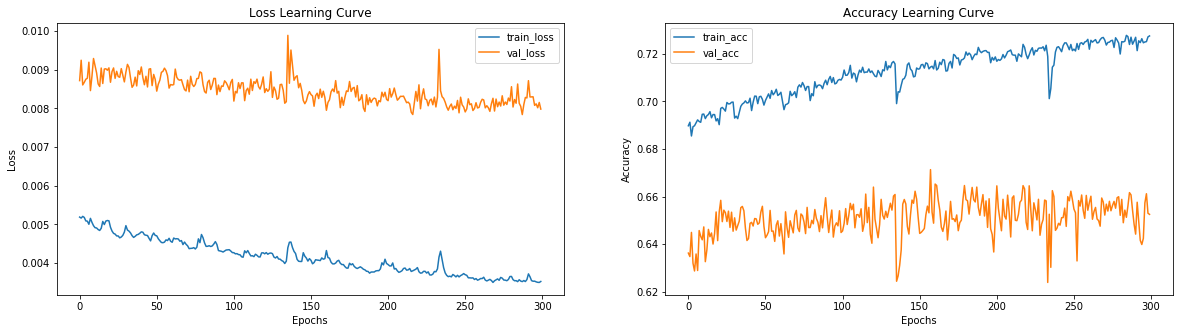

Loss: 0.0093 	Accuracy: 0.625


In [0]:
history, l2_03 = fit(model=l2_03, epochs=300, train_gen=train_generator, val_gen=val_generator, verbose=0, callbacks_list=None)
plotHistory(history)
pred_l2_03_300 = predict(model=l2_03, X_inres=test_inres, X=test_X, Y=test_Y)

In [0]:
plotResult(true=test, pred_arr_list=[pred_l2_03_300], pred_label_list=['L2, DR = 0.3, 300'], num_imgs=len(test))

Output hidden; open in https://colab.research.google.com to view.

In [0]:
plotResult(true=test, pred_arr_list=[pred_l2_03_100, pred_l2_03_300], 
           pred_label_list=['L2, DR = 0.3, 100', 'L2, DR = 0.3, 300'], 
           num_imgs=len(test))

Output hidden; open in https://colab.research.google.com to view.

Epoch 1/500
11/11 [==============================] - 16s 1s/step - loss: 0.0033 - accuracy: 0.7293 - val_loss: 0.0081 - val_accuracy: 0.6577
Epoch 2/500
11/11 [==============================] - 14s 1s/step - loss: 0.0034 - accuracy: 0.7315 - val_loss: 0.0080 - val_accuracy: 0.6634
Epoch 3/500
11/11 [==============================] - 14s 1s/step - loss: 0.0033 - accuracy: 0.7306 - val_loss: 0.0082 - val_accuracy: 0.6552
Epoch 4/500
11/11 [==============================] - 14s 1s/step - loss: 0.0034 - accuracy: 0.7303 - val_loss: 0.0080 - val_accuracy: 0.6626
Epoch 5/500
11/11 [==============================] - 14s 1s/step - loss: 0.0034 - accuracy: 0.7320 - val_loss: 0.0081 - val_accuracy: 0.6524
Epoch 6/500
11/11 [==============================] - 14s 1s/step - loss: 0.0034 - accuracy: 0.7282 - val_loss: 0.0081 - val_accuracy: 0.6456
Epoch 7/500
11/11 [==============================] - 14s 1s/step - loss: 0.0034 - accuracy: 0.7283 - val_loss: 0.0081 - val_accuracy: 0.6518
Epoch 8/500
1

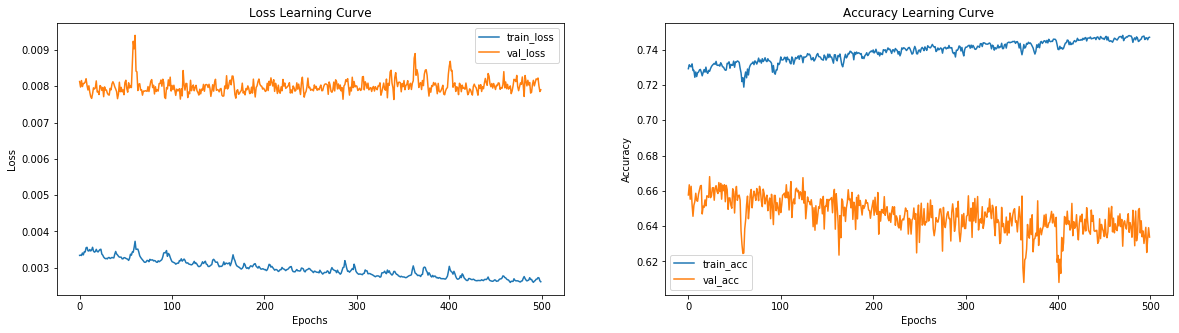

Loss: 0.0093 	Accuracy: 0.6187


In [0]:
history, l2_03 = fit(model=l2_03, epochs=500, train_gen=train_generator, val_gen=val_generator, verbose=1, callbacks_list=None)
plotHistory(history)
pred_l2_03_500 = predict(model=l2_03, X_inres=test_inres, X=test_X, Y=test_Y)

In [0]:
plotResult(true=test, pred_arr_list=[pred_l2_03_100, pred_l2_03_300, pred_l2_03_500], 
           pred_label_list=['L2, DR = 0.3, 100', 'L2, DR = 0.3, 300', 'L2, DR = 0.3, 500'], 
           num_imgs=len(test))

Output hidden; open in https://colab.research.google.com to view.

### Batch Norm with No Dropout

In [0]:
l2 = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                kernel_initializer='he_normal', kernel_regularizer=None, 
                addBN=True, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='l2')
l2.summary()

Model: "l2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
en_stridePool_64 (Conv2D)       (None, 128, 128, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
bn_en_stridePool_64 (BatchNorma (None, 128, 128, 64) 256         en_stridePool_64[0][0]           
__________________________________________________________________________________________________
act_en_stridePool_64 (Activatio (None, 128, 128, 64) 0           bn_en_stridePool_64[0][0]        
_________________________________________________________________________________________________


	Total Training Time: 6594.93 seconds
Train Loss: 0.0033 	Accuracy: 0.725
Val   Loss: 0.0166 	Accuracy: 0.6


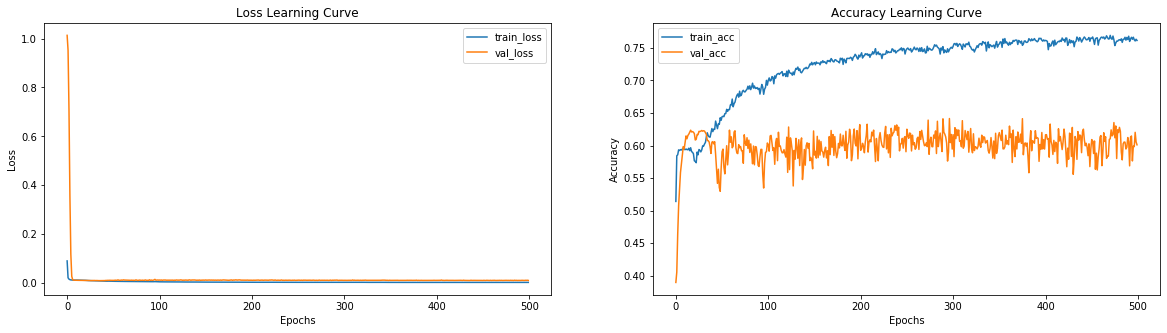

Loss: 0.011 	Accuracy: 0.6042


In [0]:
history, l2 = fit(model=l2, epochs=500, train_gen=train_generator, val_gen=val_generator, verbose=0, callbacks_list=None)
plotHistory(history)
pred_l2 = predict(model=l2, X_inres=test_inres, X=test_X, Y=test_Y)

In [0]:
plotResult(true=test, pred_arr_list=[pred_l2], pred_label_list=['L2 - No BN (500)'], num_imgs=len(test))

Output hidden; open in https://colab.research.google.com to view.

# ALL Dataset

In [0]:
BATCH_SIZE = 32
TARGET_SIZE = (256, 256)

In [0]:
train, val, test = getImageArray(FOLDER_PATH='./DATA/ALL', target_size=TARGET_SIZE, isColor=True, isSplit=True)

Finished converting 1135 images as numpy arrays!
Train Shape: (918, 256, 256, 3)
Val   Shape: (103, 256, 256, 3)
Test  Shape: (114, 256, 256, 3)


In [0]:
train_generator = DataGenerator(img_arr=train, batch_size=BATCH_SIZE, isInres=True)
val_generator = DataGenerator(img_arr=val, batch_size=BATCH_SIZE, isInres=True)

In [0]:
test_lab = rgb2lab(test * 1.0/255)
test_X = test_lab[:, :, :, 0] / 100
test_X = np.expand_dims(test_X, axis=3)
test_Y = test_lab[:, :, :, 1:] / 128

test_inres = np.array([resize(img, (299, 299)) for img in test])
test_inres = np.expand_dims(rgb2gray(test_inres), axis=3)
test_inres = np.concatenate([test_inres, test_inres, test_inres], axis=3)
test_inres = preprocess_input(test_inres)
test_inres = inres_model.predict(test_inres)
test_inres = test_inres/np.max(test_inres)

print('\nShape of TEST:      ', test.shape, 'with pixels in range', test.min(), 'to', test.max())
print('Shape of TEST INRES:', test_inres.shape, 'with pixels in range', test_inres.min(), 'to', test_inres.max())
print('Shape of TEST LAB:  ', test_lab.shape, 'with pixels in range', test_lab.min(), 'to', test_lab.max())
print('Shape of TEST X:    ', test_X.shape, 'with pixels in range', test_X.min(), 'to', test_X.max())
print('Shape of TEST Y:    ', test_Y.shape, 'with pixels in range', test_Y.min(), 'to', test_Y.max())


Shape of TEST:       (114, 256, 256, 3) with pixels in range 0.0 to 255.0
Shape of TEST INRES: (114, 1536) with pixels in range 0.0 to 1.0
Shape of TEST LAB:   (114, 256, 256, 3) with pixels in range -66.76764716140148 to 100.0
Shape of TEST X:     (114, 256, 256, 1) with pixels in range 0.0 to 1.0
Shape of TEST Y:     (114, 256, 256, 2) with pixels in range -0.5216222434484491 to 0.6995922940852544


## Models

In [0]:
l2_BN = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                   num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                   kernel_initializer='he_normal', kernel_regularizer=None, 
                   addBN=True, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='l2_BN')
l2_BN.summary()

Model: "l2_BN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
en_stridePool_64 (Conv2D)       (None, 128, 128, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
bn_en_stridePool_64 (BatchNorma (None, 128, 128, 64) 256         en_stridePool_64[0][0]           
__________________________________________________________________________________________________
act_en_stridePool_64 (Activatio (None, 128, 128, 64) 0           bn_en_stridePool_64[0][0]        
______________________________________________________________________________________________

In [0]:
l2_BN_DR_03 = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                   num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                   kernel_initializer='he_normal', kernel_regularizer=None, 
                   addBN=True, addDR=True, dRate=0.3, optimizer='adam', loss='mse', model_name='l2_BN')
l2_BN_DR_03.summary()

Model: "l2_BN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
en_stridePool_64 (Conv2D)       (None, 128, 128, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
bn_en_stridePool_64 (BatchNorma (None, 128, 128, 64) 256         en_stridePool_64[0][0]           
__________________________________________________________________________________________________
dr_en_stridePool_64 (Dropout)   (None, 128, 128, 64) 0           bn_en_stridePool_64[0][0]        
______________________________________________________________________________________________

## Experiments

### Batch Normalization + DR 0.3 + EarlyStopping (500 Epochs)

In [0]:
history, l2_BN_DR_03 = fit(model=l2_BN_DR_03, epochs=500, train_gen=train_generator, val_gen=val_generator, verbose=1, 
                           callbacks_list=[ModelCheckpoint('./l2_BN_DR_03_500_ES_weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True), 
                                           EarlyStopping(patience=20, monitor='loss', verbose=1)])
plotHistory(history)

Epoch 1/500
28/29 [===========================>..] - ETA: 1s - loss: 0.0853 - accuracy: 0.6184
Epoch 00001: val_loss improved from inf to 0.89438, saving model to ./l2_BN_DR_03_500_ES_weights.hdf5
29/29 [==============================] - 49s 2s/step - loss: 0.0843 - accuracy: 0.6205 - val_loss: 0.8944 - val_accuracy: 0.6835
Epoch 2/500
28/29 [===========================>..] - ETA: 1s - loss: 0.0385 - accuracy: 0.6660
Epoch 00002: val_loss improved from 0.89438 to 0.22922, saving model to ./l2_BN_DR_03_500_ES_weights.hdf5
29/29 [==============================] - 39s 1s/step - loss: 0.0381 - accuracy: 0.6666 - val_loss: 0.2292 - val_accuracy: 0.3481
Epoch 3/500
28/29 [===========================>..] - ETA: 1s - loss: 0.0277 - accuracy: 0.6820
Epoch 00003: val_loss improved from 0.22922 to 0.02106, saving model to ./l2_BN_DR_03_500_ES_weights.hdf5
29/29 [==============================] - 39s 1s/step - loss: 0.0278 - accuracy: 0.6856 - val_loss: 0.0211 - val_accuracy: 0.7004
Epoch 4/500
28

KeyboardInterrupt: ignored

In [0]:
pred_l2_BN_DR_03 = predict(model=l2_BN_DR_03, X_inres=test_inres, X=test_X, Y=test_Y)
plotResult(true=test, pred_arr_list=[pred_l2_BN_DR_03], pred_label_list=['L2 - BN + DR 0.3'], num_imgs=50)

# AE + Dense Layer Inres Model

## Models

In [0]:
l2 = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                kernel_initializer='he_normal', kernel_regularizer=None, 
                addBN=False, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='l2')
l2.summary()

Model: "l2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
en_stridePool_64 (Conv2D)       (None, 64, 64, 64)   640         input[0][0]                      
__________________________________________________________________________________________________
act_en_stridePool_64 (Activatio (None, 64, 64, 64)   0           en_stridePool_64[0][0]           
__________________________________________________________________________________________________
en_128 (Conv2D)                 (None, 64, 64, 128)  73856       act_en_stridePool_64[0][0]       
_________________________________________________________________________________________________

In [0]:
l2_BN = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                kernel_initializer='he_normal', kernel_regularizer=None, 
                addBN=True, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='l2_BN')

In [0]:
l2_BN_DR_03 = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                         num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                         kernel_initializer='he_normal', kernel_regularizer=None, 
                         addBN=True, addDR=True, dRate=0.3, optimizer='adam', loss='mse', model_name='l2_BN_DR_03')

## Experiment (Oxford Flowers Dataset)

In [0]:
train, val, test = getImageArray(FOLDER_PATH='./DATA/Flower-17', target_size=TARGET_SIZE, val_split=0.2, isColor=True, isSplit=True)

Finished converting 1360 images as numpy arrays!
Train Shape: (979, 128, 128, 3)
Val   Shape: (245, 128, 128, 3)
Test  Shape: (136, 128, 128, 3)


In [0]:
train_generator = DataGenerator(img_arr=train, batch_size=BATCH_SIZE, isInres=True)
val_generator = DataGenerator(img_arr=val, batch_size=BATCH_SIZE, isInres=True)

In [0]:
test_lab = rgb2lab(test * 1.0/255)
test_X = test_lab[:, :, :, 0] / 100
test_X = np.expand_dims(test_X, axis=3)
test_Y = test_lab[:, :, :, 1:] / 128

test_inres = test * 1.0/255
test_inres = np.expand_dims(rgb2gray(test_inres), axis=3)
test_inres = np.concatenate([test_inres, test_inres, test_inres], axis=3)
test_inres = inres_model.predict(test_inres)

print('\nShape of TEST:      ', test.shape, 'with pixels in range', test.min(), 'to', test.max())
print('Shape of TEST INRES:', test_inres.shape, 'with pixels in range', test_inres.min(), 'to', test_inres.max())
print('Shape of TEST LAB:  ', test_lab.shape, 'with pixels in range', test_lab.min(), 'to', test_lab.max())
print('Shape of TEST X:    ', test_X.shape, 'with pixels in range', test_X.min(), 'to', test_X.max())
print('Shape of TEST Y:    ', test_Y.shape, 'with pixels in range', test_Y.min(), 'to', test_Y.max())


Shape of TEST:       (136, 128, 128, 3) with pixels in range 0.0 to 255.0
Shape of TEST INRES: (136, 1536) with pixels in range 0.0 to 16.077923
Shape of TEST LAB:   (136, 128, 128, 3) with pixels in range -80.95149913804107 to 100.0
Shape of TEST X:     (136, 128, 128, 1) with pixels in range 0.0 to 1.0
Shape of TEST Y:     (136, 128, 128, 2) with pixels in range -0.6324335870159459 to 0.7381103302849863


### Baseline (100 Epochs) - 256 x 256

Epoch 1/100
31/31 [==============================] - 35s 1s/step - loss: 1.0650 - mse: 1.0643 - val_loss: 1.1282 - val_mse: 1.1281
Epoch 2/100
31/31 [==============================] - 23s 740ms/step - loss: 0.7471 - mse: 0.7424 - val_loss: 0.0386 - val_mse: 0.0387
Epoch 3/100
31/31 [==============================] - 24s 765ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0258 - val_mse: 0.0261
Epoch 4/100
31/31 [==============================] - 24s 763ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0239 - val_mse: 0.0241
Epoch 5/100
31/31 [==============================] - 24s 774ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0236 - val_mse: 0.0239
Epoch 6/100
31/31 [==============================] - 24s 769ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0273 - val_mse: 0.0275
Epoch 7/100
31/31 [==============================] - 24s 765ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0228 - val_mse: 0.0230
Epoch 8/100
31/31 [==============================] - 24s 763ms/st

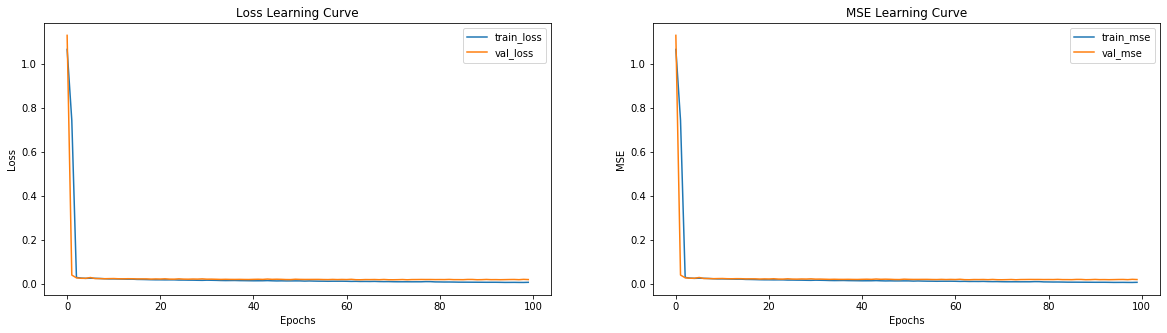

In [0]:
history, l2 = fit(model=l2, epochs=100, train_gen=train_generator, val_gen=val_generator, verbose=1, callbacks_list=None)
plotHistory(history)

In [0]:
pred_l2 = predict(model=l2, X_inres=test_inres, X=test_X, Y=test_Y)
plotResult(true=test, pred_arr_list=[pred_l2], pred_label_list=['L2'], num_imgs=50)

Output hidden; open in https://colab.research.google.com to view.

### Batch Norm Vs. Batch Norm + Dropout of 0.3 (100 Epochs) -- 128 x 128

Epoch 1/100
16/16 [==============================] - 11s 687ms/step - loss: 0.1277 - mae: 0.2486 - val_loss: 0.9101 - val_mae: 0.9326
Epoch 2/100
16/16 [==============================] - 7s 453ms/step - loss: 0.0410 - mae: 0.1424 - val_loss: 0.8610 - val_mae: 0.8986
Epoch 3/100
16/16 [==============================] - 8s 496ms/step - loss: 0.0288 - mae: 0.1249 - val_loss: 0.6942 - val_mae: 0.7728
Epoch 4/100
16/16 [==============================] - 8s 491ms/step - loss: 0.0252 - mae: 0.1177 - val_loss: 0.3253 - val_mae: 0.4707
Epoch 5/100
16/16 [==============================] - 8s 493ms/step - loss: 0.0243 - mae: 0.1157 - val_loss: 0.0890 - val_mae: 0.2190
Epoch 6/100
16/16 [==============================] - 8s 531ms/step - loss: 0.0231 - mae: 0.1129 - val_loss: 0.0368 - val_mae: 0.1438
Epoch 7/100
16/16 [==============================] - 8s 482ms/step - loss: 0.0227 - mae: 0.1111 - val_loss: 0.0297 - val_mae: 0.1293
Epoch 8/100
16/16 [==============================] - 8s 483ms/step -

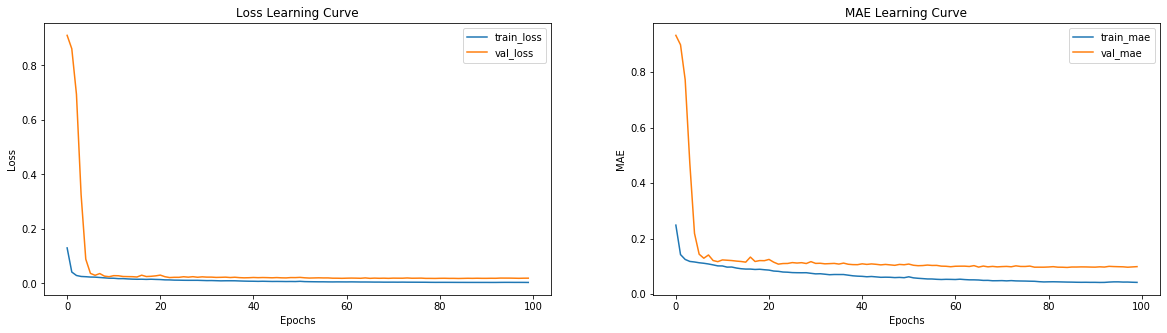

Loss: 0.0196 	MAE: 0.0987


In [0]:
history, l2_BN = fit(model=l2_BN, epochs=100, train_gen=train_generator, val_gen=val_generator, verbose=1, callbacks_list=None)
plotHistory(history)
pred_l2_BN = predict(model=l2_BN, X_inres=test_inres, X=test_X, Y=test_Y)

Epoch 1/100
16/16 [==============================] - 10s 642ms/step - loss: 0.1511 - mae: 0.2767 - val_loss: 0.9161 - val_mae: 0.9363
Epoch 2/100
16/16 [==============================] - 8s 512ms/step - loss: 0.0789 - mae: 0.1808 - val_loss: 0.3821 - val_mae: 0.5161
Epoch 3/100
16/16 [==============================] - 8s 519ms/step - loss: 0.0675 - mae: 0.1679 - val_loss: 0.3019 - val_mae: 0.4416
Epoch 4/100
16/16 [==============================] - 9s 562ms/step - loss: 0.0620 - mae: 0.1621 - val_loss: 0.3764 - val_mae: 0.5063
Epoch 5/100
16/16 [==============================] - 8s 516ms/step - loss: 0.0653 - mae: 0.1634 - val_loss: 0.1634 - val_mae: 0.2916
Epoch 6/100
16/16 [==============================] - 8s 511ms/step - loss: 0.0540 - mae: 0.1514 - val_loss: 0.0552 - val_mae: 0.1518
Epoch 7/100
16/16 [==============================] - 8s 516ms/step - loss: 0.0531 - mae: 0.1472 - val_loss: 0.0635 - val_mae: 0.1632
Epoch 8/100
16/16 [==============================] - 8s 524ms/step -

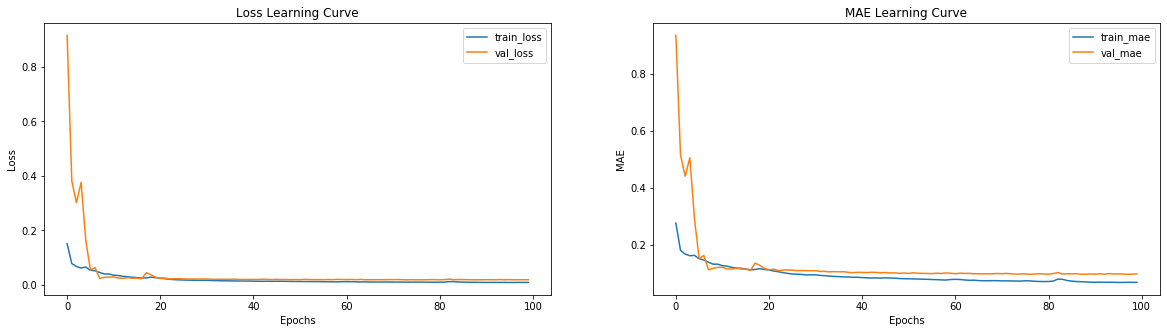

Loss: 0.0186 	MAE: 0.0954


In [0]:
history, l2_BN_DR_03 = fit(model=l2_BN_DR_03, epochs=100, train_gen=train_generator, val_gen=val_generator, verbose=1, callbacks_list=None)
plotHistory(history)
pred_l2_BN_DR_03 = predict(model=l2_BN_DR_03, X_inres=test_inres, X=test_X, Y=test_Y)

In [0]:
plotResult(true=test, pred_arr_list=[pred_l2_BN, pred_l2_BN_DR_03], 
           pred_label_list=['L2 + BN', 'L2 + BN + DR (0.3)'], num_imgs=50)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# SSIM Scores
print('BN:', getSSIM(test, pred_l2_BN))
print('BN + DR 0.3:', getSSIM(test, pred_l2_BN_DR_03))

BN: 0.16377245
BN + DR 0.3: 0.15660232


# Visual Genome Dataset (256 x 256 - Test 5K Images)

In [0]:
train = np.load('./DATA/vg-test-5K-256.npy')
train, test = train_test_split(train, test_size=0.1)
train, val = train_test_split(train, test_size=0.2)
print('Train Shape:', train.shape)
print('Val   Shape:', val.shape)
print('Test  Shape:', test.shape)

Train Shape: (3600, 256, 256, 3)
Val   Shape: (900, 256, 256, 3)
Test  Shape: (500, 256, 256, 3)


In [0]:
train_generator = DataGenerator(img_arr=train, batch_size=BATCH_SIZE, isInres=True)
val_generator = DataGenerator(img_arr=val, batch_size=BATCH_SIZE, isInres=True)

In [0]:
test_lab = rgb2lab(test * 1.0/255)
test_X = test_lab[:, :, :, 0] / 100
test_X = np.expand_dims(test_X, axis=3)
test_Y = test_lab[:, :, :, 1:] / 128

test_inres = test * 1.0/255
test_inres = np.expand_dims(rgb2gray(test_inres), axis=3)
test_inres = np.concatenate([test_inres, test_inres, test_inres], axis=3)
test_inres = inres_model.predict(test_inres)

print('\nShape of TEST:      ', test.shape, 'with pixels in range', test.min(), 'to', test.max())
print('Shape of TEST INRES:', test_inres.shape, 'with pixels in range', test_inres.min(), 'to', test_inres.max())
print('Shape of TEST LAB:  ', test_lab.shape, 'with pixels in range', test_lab.min(), 'to', test_lab.max())
print('Shape of TEST X:    ', test_X.shape, 'with pixels in range', test_X.min(), 'to', test_X.max())
print('Shape of TEST Y:    ', test_Y.shape, 'with pixels in range', test_Y.min(), 'to', test_Y.max())


Shape of TEST:       (500, 256, 256, 3) with pixels in range 0.0 to 255.0
Shape of TEST INRES: (500, 1536) with pixels in range 0.0 to 7.108236
Shape of TEST LAB:   (500, 256, 256, 3) with pixels in range -107.13462056753032 to 100.0
Shape of TEST X:     (500, 256, 256, 1) with pixels in range 0.0 to 1.0
Shape of TEST Y:     (500, 256, 256, 2) with pixels in range -0.8369892231838306 to 0.7414199807926092


## Final Model -- L2 + BN with no Dropout (adam)

Model: "fin"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
en_stridePool_64 (Conv2D)       (None, 128, 128, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
bn_en_stridePool_64 (BatchNorma (None, 128, 128, 64) 256         en_stridePool_64[0][0]           
__________________________________________________________________________________________________
act_en_stridePool_64 (Activatio (None, 128, 128, 64) 0           bn_en_stridePool_64[0][0]        
________________________________________________________________________________________________

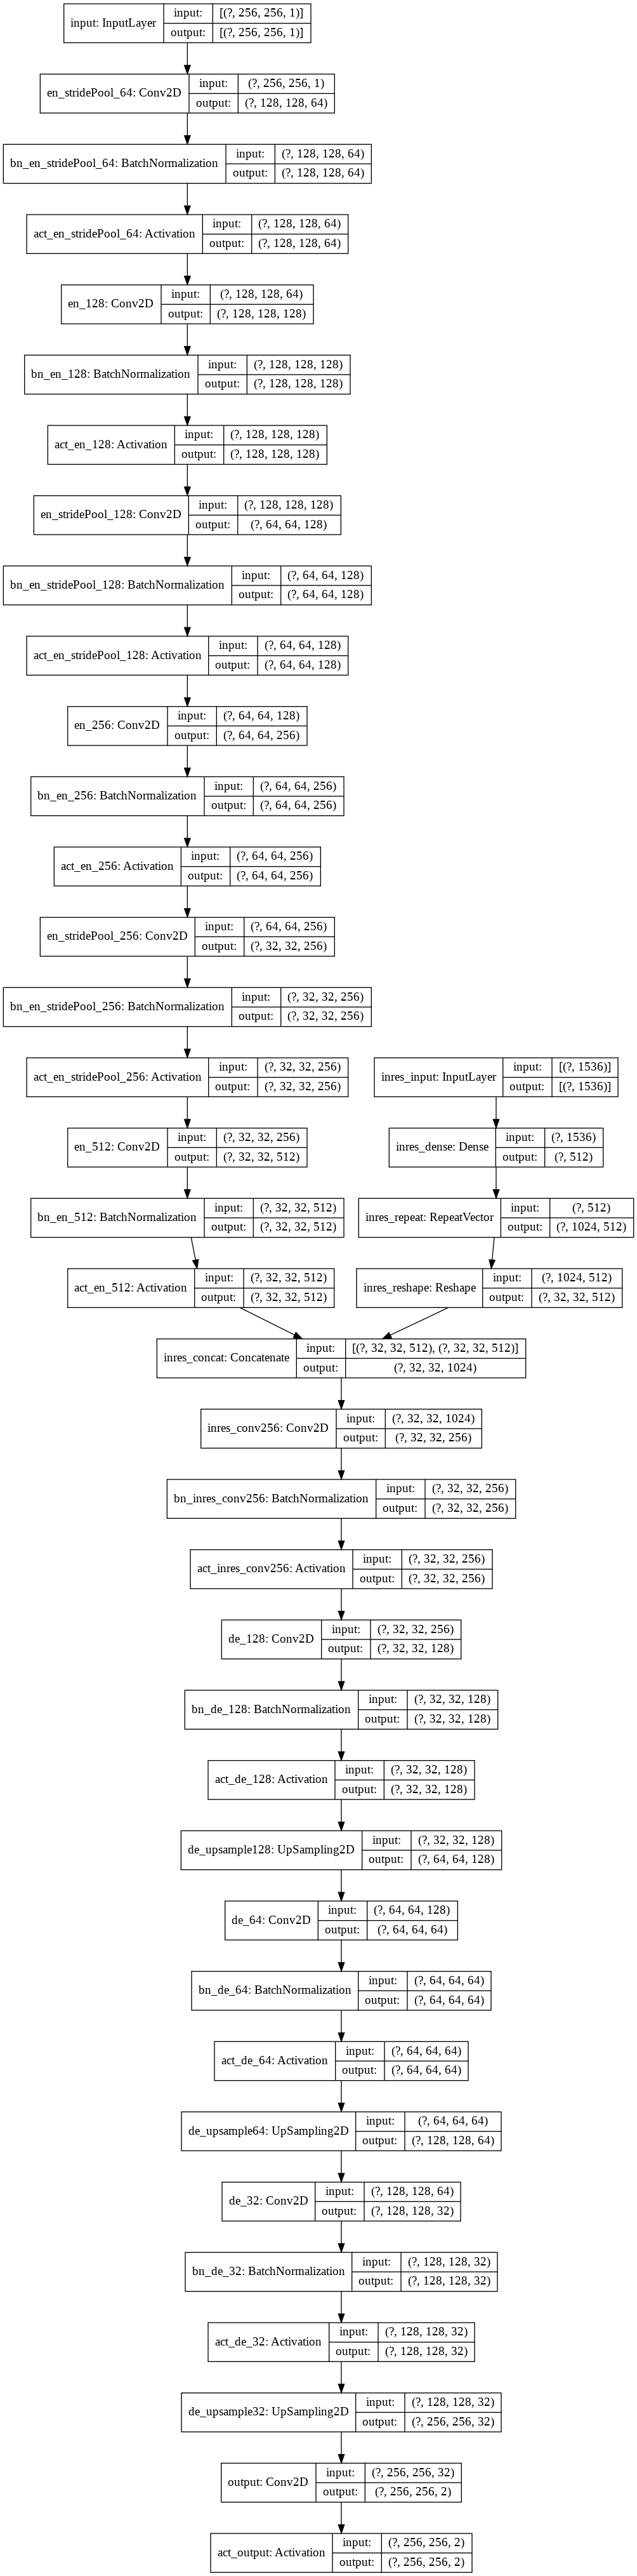

In [0]:
fin = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                 num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                 kernel_initializer='he_normal', kernel_regularizer=None, 
                 addBN=True, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='fin')
fin.summary()
plot_model(fin, show_shapes=True)

Epoch 1/300
57/57 [==============================] - 106s 2s/step - loss: 0.0352 - mae: 0.1092 - val_loss: 0.2169 - val_mae: 0.3521
Epoch 2/300
57/57 [==============================] - 88s 2s/step - loss: 0.0132 - mae: 0.0778 - val_loss: 0.0176 - val_mae: 0.0913
Epoch 3/300
57/57 [==============================] - 88s 2s/step - loss: 0.0120 - mae: 0.0751 - val_loss: 0.0146 - val_mae: 0.0811
Epoch 4/300
57/57 [==============================] - 88s 2s/step - loss: 0.0115 - mae: 0.0731 - val_loss: 0.0147 - val_mae: 0.0835
Epoch 5/300
57/57 [==============================] - 89s 2s/step - loss: 0.0109 - mae: 0.0713 - val_loss: 0.0141 - val_mae: 0.0827
Epoch 6/300
57/57 [==============================] - 89s 2s/step - loss: 0.0105 - mae: 0.0700 - val_loss: 0.0140 - val_mae: 0.0794
Epoch 7/300
57/57 [==============================] - 89s 2s/step - loss: 0.0101 - mae: 0.0688 - val_loss: 0.0146 - val_mae: 0.0802
Epoch 8/300
57/57 [==============================] - 91s 2s/step - loss: 0.0099 - 

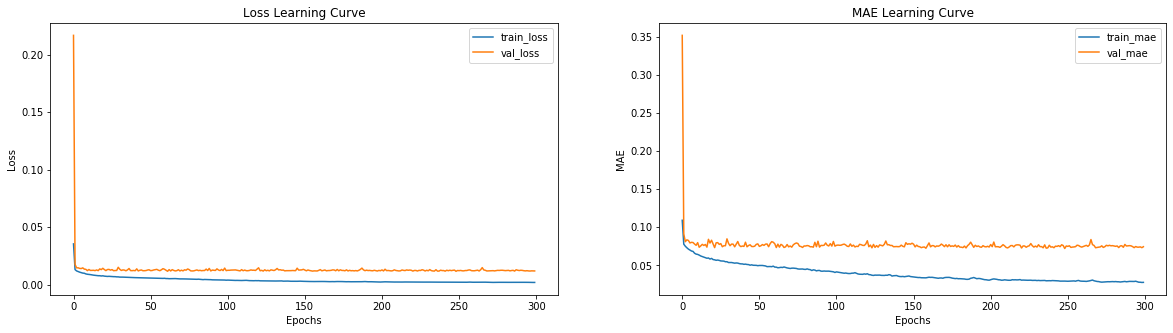

Loss: 0.0125 	MAE: 0.0753
SSIM: 0.14080295
DelE: [[[113.43856049 134.04650128 159.89990704 ... 101.99758494  99.57921067
   102.66737054]
  [158.46148772 117.63792294 156.20961264 ... 100.65870799  98.59034735
    99.64320056]
  [174.10062753 146.51157096 151.77272563 ... 100.1032533  100.01875764
    98.98872382]
  ...
  [107.91220666  15.36597045 100.72208193 ... 140.75926013 144.14971907
   136.56182164]
  [ 79.05189149 107.73120233  98.1357356  ... 147.66406635 144.30435662
   135.85364617]
  [ 44.23050377 106.10174108 119.94747516 ... 140.93974692 141.37745878
   140.20930839]]

 [[124.24795334 123.59105682 124.03357031 ... 124.79825762 124.72248003
   124.85142953]
  [124.29481309 122.30459709 122.71669263 ... 124.62488995 123.91122966
   124.47486516]
  [125.49145868 122.16775813 123.24042303 ... 124.08771328 124.13110295
   124.0166853 ]
  ...
  [ 46.69117118  83.17972626  41.24302243 ...  28.12410666  46.3183398
    31.9886757 ]
  [ 58.15983076  84.97135583  40.84941258 ...  4

In [0]:
history, fin = fit(model=fin, epochs=300, train_gen=train_generator, val_gen=val_generator, verbose=1, 
                   callbacks_list=[ModelCheckpoint('./L2BN_VG_weights_best.hdf5', save_best_only=False, save_weights_only=False)])
plotHistory(history)
pred_fin = predict(model=fin, X_inres=test_inres, X=test_X, Y=test_Y)
print('SSIM:', getSSIM(test, pred_fin))
print('DelE:', deltaE_ciede2000(rgb2lab(test), rgb2lab(pred_fin)))

In [0]:
fin.load_weights('./L2BN_VG_weights_best.hdf5')
pred_fin = predict(model=fin, X_inres=test_inres, X=test_X, Y=test_Y)


Loss: 0.0125 	MAE: 0.0753


In [0]:
plotResult(true=test, pred_arr_list=[pred_fin], pred_label_list=['L2 + BN'], num_imgs=50)

Output hidden; open in https://colab.research.google.com to view.

### Learning Rate Tuning - Learning Rate Scheduler (RMSprop)

In [0]:
fin_LR = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                    num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                    kernel_initializer='he_normal', kernel_regularizer=None, 
                    addBN=True, addDR=False, dRate=0.0, 
                    optimizer=RMSprop(learning_rate=0.003), loss='mse', model_name='fin_LR')

In [0]:
def scheduler(epoch):
    if epoch % 25 == 0 and epoch != 0:
        lr = K.get_value(fin_LR.optimizer.lr)
        K.set_value(fin_LR.optimizer.lr, lr * 0.2)
        print("lr changed to {}".format(lr * 0.2))
    return K.get_value(fin_LR.optimizer.lr)

Epoch 1/150
57/57 [==============================] - 118s 2s/step - loss: 0.0537 - mae: 0.1341 - val_loss: 0.9252 - val_mae: 0.9508
Epoch 2/150
57/57 [==============================] - 97s 2s/step - loss: 0.0303 - mae: 0.1027 - val_loss: 0.0366 - val_mae: 0.1064
Epoch 3/150
57/57 [==============================] - 94s 2s/step - loss: 0.0269 - mae: 0.0969 - val_loss: 0.0458 - val_mae: 0.1208
Epoch 4/150
57/57 [==============================] - 95s 2s/step - loss: 0.0220 - mae: 0.0905 - val_loss: 0.3444 - val_mae: 0.4081
Epoch 5/150
57/57 [==============================] - 103s 2s/step - loss: 0.0177 - mae: 0.0825 - val_loss: 0.0314 - val_mae: 0.1097
Epoch 6/150
57/57 [==============================] - 95s 2s/step - loss: 0.0145 - mae: 0.0777 - val_loss: 0.0204 - val_mae: 0.0983
Epoch 7/150
57/57 [==============================] - 96s 2s/step - loss: 0.0118 - mae: 0.0734 - val_loss: 0.0131 - val_mae: 0.0752
Epoch 8/150
57/57 [==============================] - 96s 2s/step - loss: 0.0114 -

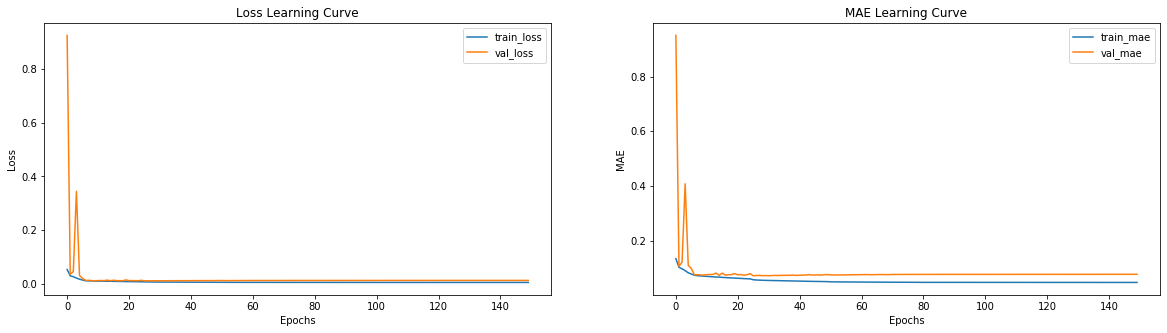

Loss: 0.0136 	MAE: 0.078
SSIM: 0.13990545


In [0]:
history, fin_LR = fit(model=fin_LR, epochs=150, train_gen=train_generator, val_gen=val_generator, verbose=1, 
                      callbacks_list=[ModelCheckpoint('./L2BN_VG_LR-Tune_weights_best.hdf5', save_best_only=False, save_weights_only=False), 
                                      LearningRateScheduler(scheduler)])
                                      #ReduceLROnPlateau(monitor='train_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min', cooldown=1)])
plotHistory(history)
pred_fin_LR = predict(model=fin_LR, X_inres=test_inres, X=test_X, Y=test_Y)
print('SSIM:', getSSIM(test, pred_fin_LR))

In [0]:
plotResult(true=test, pred_arr_list=[pred_fin_LR], pred_label_list=['FIN_LR'], num_imgs=50)

Output hidden; open in https://colab.research.google.com to view.

# Data Augmentation + Normalization of pixels to [-1, 1]

## Man Made

In [0]:
train, test = getImageArray('./DATA/ManMade')

Finished converting 419 images as numpy arrays!
Image pixels are in range 0.0 to 1.0
Train Shape: (377, 256, 256, 3)
Test  Shape: (42, 256, 256, 3)


In [0]:
test_X, test_inres, test_Y = getProcessedData(test)

Shape of X: (42, 256, 256, 1) with pixels in range -1.0 to 1.0
Shape of X_inres: (42, 256, 256, 1) with pixels in range 0.0 to 6.654743
Shape of Y: (42, 256, 256, 2) with pixels in range -0.4488349584049105 to 0.6992180334609845


In [0]:
train_datagen = ImageDataGenerator(data_format='channels_last', validation_split=0.2, 
                                   rotation_range=40, shear_range=0.2, zoom_range=0.2,
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True)

train_generator = DataGenerator(train_datagen.flow(train, batch_size=BATCH_SIZE, subset='training'))
val_generator = DataGenerator(train_datagen.flow(train, batch_size=BATCH_SIZE, subset='validation'))

### L2 Regularization with Learning Rate Scheduler

In [0]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * np.exp(0.1 * (10 - epoch))

In [0]:
LR = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                kernel_initializer='he_normal', kernel_regularizer=l2(0.01), 
                addBN=True, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='LR')


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
5/5 [==============================] - 13s 3s/step - loss: 33.9113 - mae: 0.3817 - val_loss: 30.8134 - val_mae: 1.0310

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/100
5/5 [==============================] - 10s 2s/step - loss: 27.3880 - mae: 0.1743 - val_loss: 24.5473 - val_mae: 0.7982

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/100
5/5 [==============================] - 11s 2s/step - loss: 21.8145 - mae: 0.1157 - val_loss: 19.7516 - val_mae: 0.8868

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/100
5/5 [==============================] - 10s 2s/step - loss: 17.3169 - mae: 0.0956 - val_loss: 15.4745 - val_mae: 0.6517

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
Epoch 5/100
5/5 [==============================] - 11s 2s/step - loss: 13.6821 - mae: 0.0848 - val_loss: 11.9846 - val_mae: 0.2746


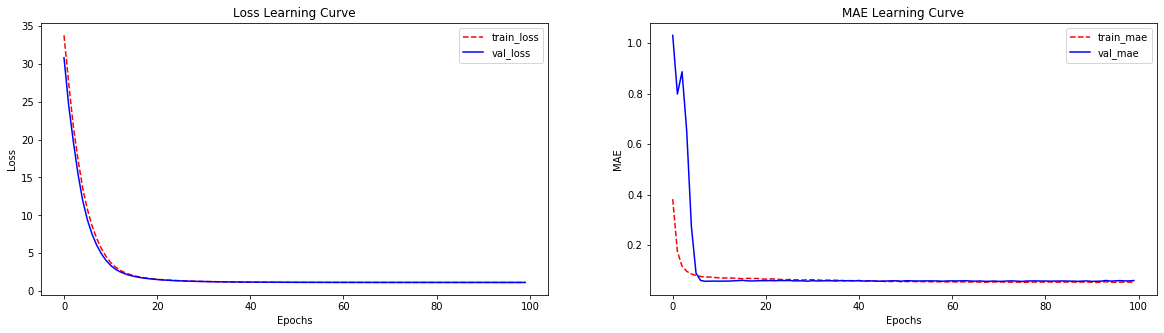

NameError: ignored

In [0]:
history, LR = fit(model=LR, epochs=100, train_gen=train_generator, val_gen=val_generator, verbose=1, 
                  callbacks_list=[LearningRateScheduler(scheduler, verbose=1)])
plotHistory(history)

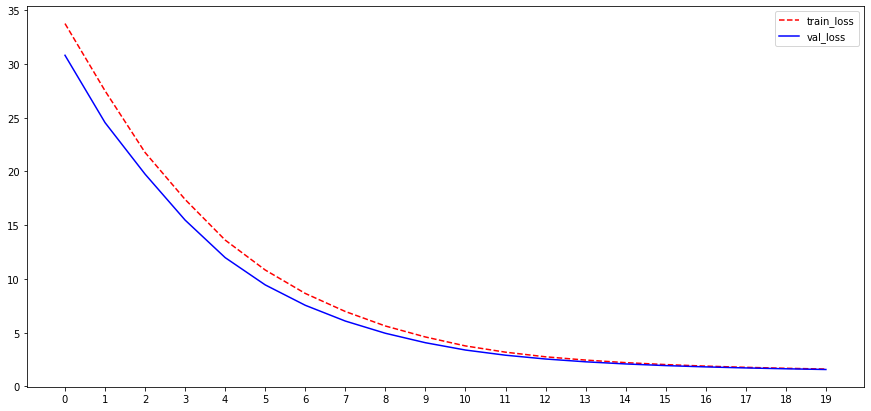

In [0]:
# plot loss history of 1st 20 epochs
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'][:20], 'r--', label='train_loss')
plt.plot(history.history['val_loss'][:20], 'b-', label='val_loss')
plt.xticks(range(0, 20, 1))
plt.legend(loc='best')
plt.show()

In [0]:
pred_LR = predict(model=LR, X=test_X, X_inres=test_inres, Y=test_Y)

Loss: 1.1381 	MAE: 0.0682


In [0]:
# plot prediction images
fig = plt.figure(figsize=(23, 30))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 6), axes_pad=0.1)
for ax, im in zip(grid, pred_LR[:30]):
    ax.imshow(lab2rgb(im))
    ax.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### No L2 Regularization + Default Learning Rate

In [0]:
NO_REG = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                    num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                    kernel_initializer='he_normal', kernel_regularizer=None, 
                    addBN=True, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='LR')

Epoch 1/100
5/5 [==============================] - 18s 4s/step - loss: 0.1908 - mae: 0.3006 - val_loss: 0.9277 - val_mae: 0.9616
Epoch 2/100
5/5 [==============================] - 11s 2s/step - loss: 0.0389 - mae: 0.1103 - val_loss: 0.9933 - val_mae: 0.9903
Epoch 3/100
5/5 [==============================] - 11s 2s/step - loss: 0.0232 - mae: 0.0891 - val_loss: 1.0620 - val_mae: 1.0317
Epoch 4/100
5/5 [==============================] - 11s 2s/step - loss: 0.0160 - mae: 0.0815 - val_loss: 1.0695 - val_mae: 1.0289
Epoch 5/100
5/5 [==============================] - 12s 2s/step - loss: 0.0139 - mae: 0.0756 - val_loss: 1.0254 - val_mae: 1.0019
Epoch 6/100
5/5 [==============================] - 11s 2s/step - loss: 0.0119 - mae: 0.0721 - val_loss: 0.9916 - val_mae: 0.9834
Epoch 7/100
5/5 [==============================] - 11s 2s/step - loss: 0.0111 - mae: 0.0710 - val_loss: 0.9760 - val_mae: 0.9750
Epoch 8/100
5/5 [==============================] - 11s 2s/step - loss: 0.0109 - mae: 0.0707 - val

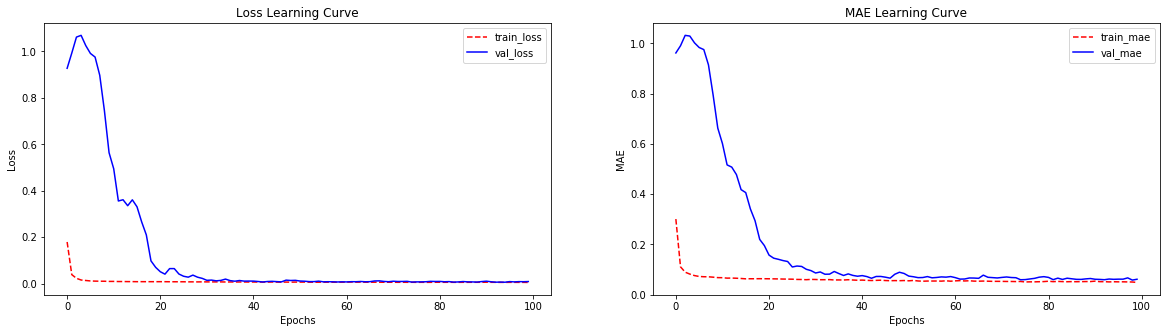

Loss: 0.0097 	MAE: 0.0668


In [0]:
history, NO_REG = fit(model=NO_REG, epochs=100, train_gen=train_generator, val_gen=val_generator, verbose=1, callbacks_list=None)
plotHistory(history)
pred_NO_REG = predict(model=NO_REG, X=test_X, X_inres=test_inres, Y=test_Y)

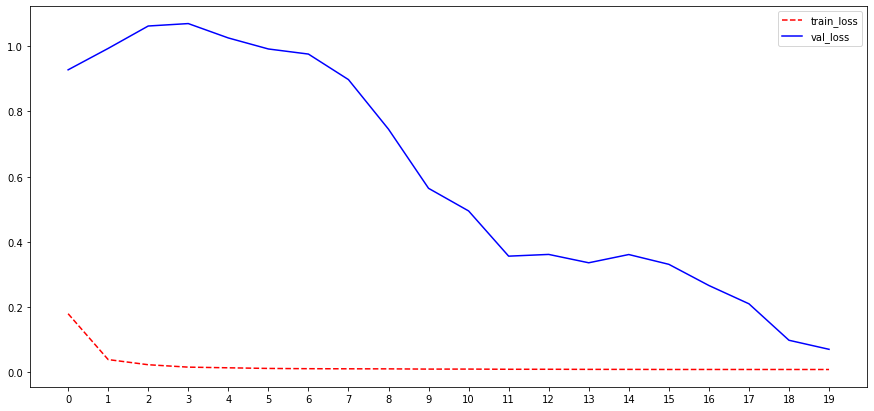

In [0]:
# plot loss history of 1st 20 epochs
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'][:20], 'r--', label='train_loss')
plt.plot(history.history['val_loss'][:20], 'b-', label='val_loss')
plt.xticks(range(0, 20, 1))
plt.legend(loc='best')
plt.show()

In [0]:
# plot prediction images
fig = plt.figure(figsize=(23, 30))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 6), axes_pad=0.1)
for ax, im in zip(grid, pred_NO_REG[:30]):
    ax.imshow(lab2rgb(im))
    ax.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Fruits

In [0]:
train, test = getImageArray('./DATA/Fruits')
test_X, test_inres, test_Y = getProcessedData(test)

Finished converting 52 images as numpy arrays!
Image pixels are in range 0.0 to 1.0
Train Shape: (46, 256, 256, 3)
Test  Shape: (6, 256, 256, 3)
Shape of X: (6, 256, 256, 1) with pixels in range -1.0 to 1.0
Shape of X_inres: (6, 256, 256, 1) with pixels in range 0.0 to 5.4986715
Shape of Y: (6, 256, 256, 2) with pixels in range -0.4662085648403634 to 0.6777699026360318


In [0]:
train_datagen = ImageDataGenerator(data_format='channels_last', validation_split=0.2, 
                                   rotation_range=40, shear_range=0.2, zoom_range=0.2,
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True)

train_generator = DataGenerator(train_datagen.flow(train, batch_size=BATCH_SIZE, subset='training'))
val_generator = DataGenerator(train_datagen.flow(train, batch_size=BATCH_SIZE, subset='validation'))

In [0]:
fin = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                 num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                 kernel_initializer='he_normal', kernel_regularizer=None, 
                 addBN=True, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='fin')

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.6721 - mae: 0.7320 - val_loss: 1.4291 - val_mae: 1.1769
Epoch 2/100
1/1 [==============================] - 1s 916ms/step - loss: 0.3788 - mae: 0.4983 - val_loss: 1.4262 - val_mae: 1.1753
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.1934 - mae: 0.3213 - val_loss: 1.4103 - val_mae: 1.1689
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.1429 - mae: 0.2585 - val_loss: 1.4092 - val_mae: 1.1678
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.1040 - mae: 0.2120 - val_loss: 1.3951 - val_mae: 1.1619
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.0837 - mae: 0.1949 - val_loss: 1.4243 - val_mae: 1.1750
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.0743 - mae: 0.1851 - val_loss: 1.4187 - val_mae: 1.1717
Epoch 8/100
1/1 [==============================] - 2s 2s/step - loss: 0.0610 - mae: 0.1624 - val_loss

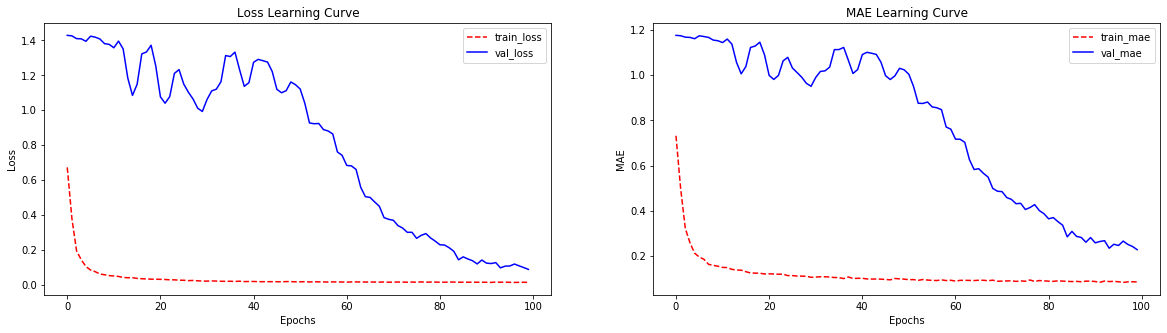

Loss: 0.0942 	MAE: 0.2142


In [0]:
history, fin = fit(model=fin, epochs=100, train_gen=train_generator, val_gen=val_generator, verbose=1, callbacks_list=None)
plotHistory(history)
pred = predict(model=fin, X=test_X, X_inres=test_inres, Y=test_Y)

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 120 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 736 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 157 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 331 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].siz

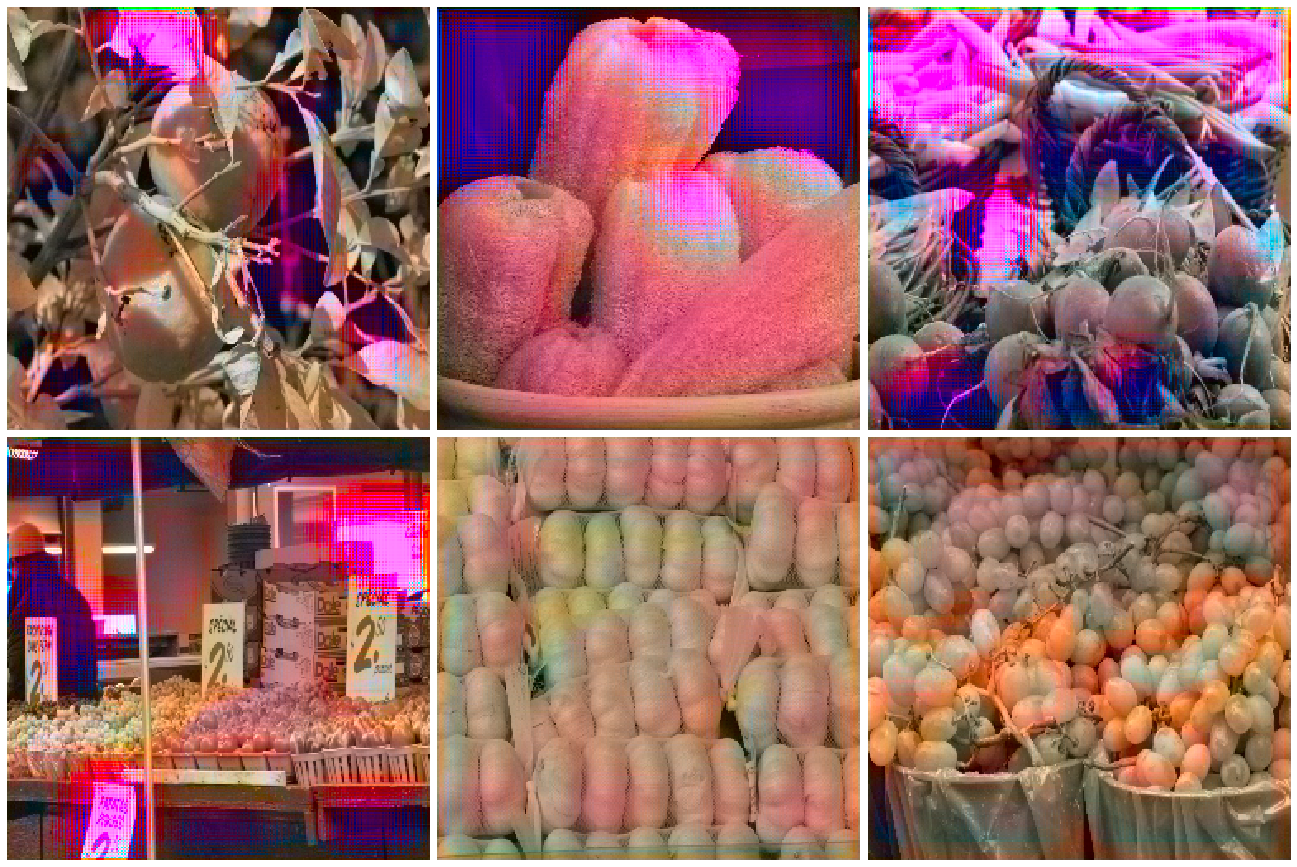

In [0]:
# plot prediction images
fig = plt.figure(figsize=(23, 30))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 3), axes_pad=0.1)
for ax, im in zip(grid, pred):
    ax.imshow(lab2rgb(im))
    ax.axis('off')
plt.show()

## Flower-17 Dataset

In [0]:
train, test = getImageArray('./DATA/Flower-17')
test_X, test_inres, test_Y = getProcessedData(test)

Finished converting 1360 images as numpy arrays!
Image pixels are in range 0.0 to 1.0
Train Shape: (1224, 256, 256, 3)
Test  Shape: (136, 256, 256, 3)
Shape of X: (136, 256, 256, 1) with pixels in range -1.0 to 1.0
Shape of X_inres: (136, 256, 256, 1) with pixels in range 0.0 to 6.083651
Shape of Y: (136, 256, 256, 2) with pixels in range -0.6325375077942755 to 0.7381103302849863


In [0]:
train_datagen = ImageDataGenerator(data_format='channels_last', validation_split=0.2, 
                                   rotation_range=40, shear_range=0.2, zoom_range=0.2,
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True)

train_generator = DataGenerator(train_datagen.flow(train, batch_size=100, subset='training'))
val_generator = DataGenerator(train_datagen.flow(train, batch_size=100, subset='validation'))

In [0]:
fin = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                 num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                 kernel_initializer='he_normal', kernel_regularizer=None, 
                 addBN=True, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='fin')

Epoch 1/100
10/10 [==============================] - 49s 5s/step - loss: 0.1151 - mae: 0.2481 - val_loss: 0.9250 - val_mae: 0.9432
Epoch 2/100
10/10 [==============================] - 34s 3s/step - loss: 0.0296 - mae: 0.1278 - val_loss: 0.9267 - val_mae: 0.9444
Epoch 3/100
10/10 [==============================] - 36s 4s/step - loss: 0.0258 - mae: 0.1188 - val_loss: 0.9253 - val_mae: 0.9406
Epoch 4/100
10/10 [==============================] - 35s 4s/step - loss: 0.0245 - mae: 0.1147 - val_loss: 0.8802 - val_mae: 0.9023
Epoch 5/100
10/10 [==============================] - 36s 4s/step - loss: 0.0232 - mae: 0.1113 - val_loss: 0.7856 - val_mae: 0.8234
Epoch 6/100
10/10 [==============================] - 36s 4s/step - loss: 0.0225 - mae: 0.1101 - val_loss: 0.7384 - val_mae: 0.7647
Epoch 7/100
10/10 [==============================] - 36s 4s/step - loss: 0.0226 - mae: 0.1099 - val_loss: 0.4446 - val_mae: 0.5617
Epoch 8/100
10/10 [==============================] - 35s 4s/step - loss: 0.0221 - m

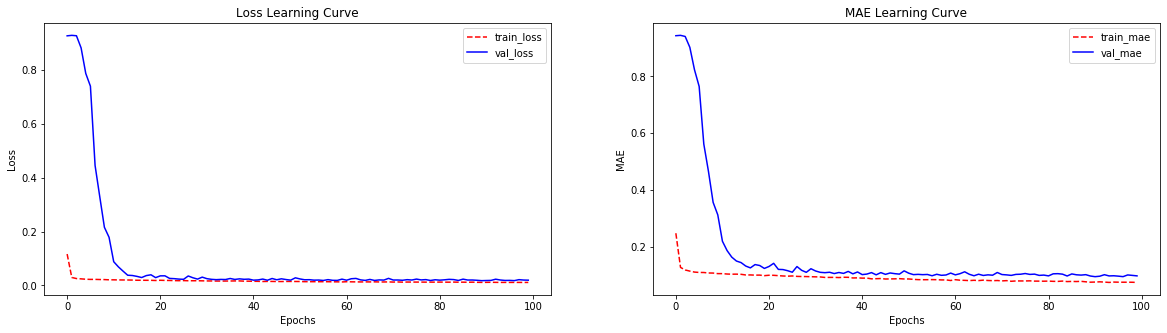

Loss: 0.0179 	MAE: 0.0938


In [0]:
history, fin = fit(model=fin, epochs=100, train_gen=train_generator, val_gen=val_generator, verbose=1, 
                   callbacks_list=[ModelCheckpoint('./flower_weights.hdf5', save_best_only=False, save_weights_only=False)])
plotHistory(history)
pred = predict(model=fin, X=test_X, X_inres=test_inres, Y=test_Y)

In [0]:
# plot prediction images
fig = plt.figure(figsize=(23, 100))
grid = ImageGrid(fig, 111, nrows_ncols=(int(np.floor(len(pred)/6)), 6), axes_pad=0.1)
for ax, im in zip(grid, pred):
    ax.imshow(lab2rgb(im))
    ax.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# plot prediction with ground truth
plotResult(true=test, pred_arr_list=[pred], pred_label_list=['Prediction'], num_imgs=50)

Output hidden; open in https://colab.research.google.com to view.

## Animals Dataset

In [0]:
train, test = getImageArray('./DATA/Animals')
test_X, test_inres, test_Y = getProcessedData(test)

Finished converting 98 images as numpy arrays!
Image pixels are in range 0.0 to 1.0
Train Shape: (88, 256, 256, 3)
Test  Shape: (10, 256, 256, 3)
Shape of X: (10, 256, 256, 1) with pixels in range -1.0 to 1.0
Shape of X_inres: (10, 256, 256, 1) with pixels in range 0.0 to 4.048338
Shape of Y: (10, 256, 256, 2) with pixels in range -0.38500387404003616 to 0.6444072727041806


In [0]:
train_datagen = ImageDataGenerator(data_format='channels_last', validation_split=0.2, 
                                   rotation_range=40, shear_range=0.2, zoom_range=0.2,
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True)

train_generator = DataGenerator(train_datagen.flow(train, batch_size=32, subset='training'))
val_generator = DataGenerator(train_datagen.flow(train, batch_size=32, subset='validation'))

In [0]:
fin = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                 num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                 kernel_initializer='he_normal', kernel_regularizer=None, 
                 addBN=True, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='fin')

Epoch 1/150
3/3 [==============================] - 5s 2s/step - loss: 0.3441 - mae: 0.4810 - val_loss: 1.2006 - val_mae: 1.0868
Epoch 2/150
3/3 [==============================] - 2s 691ms/step - loss: 0.0946 - mae: 0.1859 - val_loss: 1.2091 - val_mae: 1.0901
Epoch 3/150
3/3 [==============================] - 3s 906ms/step - loss: 0.0568 - mae: 0.1359 - val_loss: 1.2016 - val_mae: 1.0865
Epoch 4/150
3/3 [==============================] - 3s 971ms/step - loss: 0.0374 - mae: 0.1188 - val_loss: 0.8545 - val_mae: 0.9090
Epoch 5/150
3/3 [==============================] - 3s 965ms/step - loss: 0.0276 - mae: 0.1077 - val_loss: 0.8583 - val_mae: 0.9149
Epoch 6/150
3/3 [==============================] - 2s 774ms/step - loss: 0.0233 - mae: 0.1032 - val_loss: 0.8584 - val_mae: 0.9146
Epoch 7/150
3/3 [==============================] - 3s 891ms/step - loss: 0.0163 - mae: 0.0943 - val_loss: 0.8552 - val_mae: 0.9128
Epoch 8/150
3/3 [==============================] - 3s 968ms/step - loss: 0.0169 - mae:

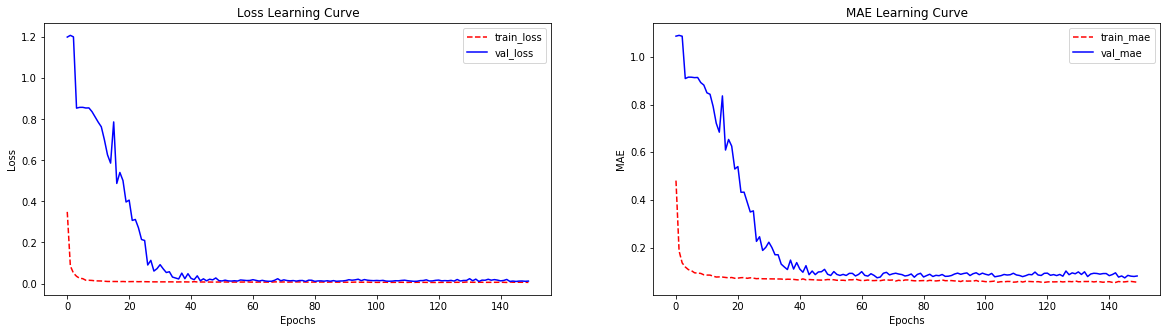

Loss: 0.0075 	MAE: 0.0681


In [0]:
history, fin = fit(model=fin, epochs=150, train_gen=train_generator, val_gen=val_generator, verbose=1, callbacks_list=None)
plotHistory(history)
pred = predict(model=fin, X=test_X, X_inres=test_inres, Y=test_Y)

In [0]:
# plot prediction images
fig = plt.figure(figsize=(23, 30))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.1)
for ax, im in zip(grid, pred):
    ax.imshow(lab2rgb(im))
    ax.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# plot prediction with ground truth
plotResult(true=test, pred_arr_list=[pred], pred_label_list=['Prediction'], num_imgs=len(pred))

Output hidden; open in https://colab.research.google.com to view.

## Visual Genome 10K data (train)

In [0]:
train = np.load('./DATA/vg-train-10K-256.npy')
train, test = train_test_split(train, test_size=0.1)
train, val = train_test_split(train, test_size=0.2)
train = train * 1.0/255
val = val * 1.0/255
test = test * 1.0/255
print('Train Shape:', train.shape)
print('Val   Shape:', val.shape)
print('Test  Shape:', test.shape)

Train Shape: (7200, 256, 256, 3)
Val   Shape: (1800, 256, 256, 3)
Test  Shape: (1000, 256, 256, 3)


In [0]:
test_X, test_inres, test_Y = getProcessedData(test)

Shape of X: (1000, 256, 256, 1) with pixels in range -1.0 to 1.0
Shape of X_inres: (1000, 256, 256, 1) with pixels in range 0.0 to 8.192011
Shape of Y: (1000, 256, 256, 2) with pixels in range -0.839167139751485 to 0.7544737829565198


In [0]:
train_datagen = ImageDataGenerator(data_format='channels_last', validation_split=0.2, 
                                   rotation_range=40, shear_range=0.2, zoom_range=0.2,
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True)

train_generator = DataGenerator(train_datagen.flow(train, batch_size=BATCH_SIZE, subset='training'))
val_generator = DataGenerator(train_datagen.flow(train, batch_size=BATCH_SIZE, subset='validation'))

In [0]:
def scheduler(epoch):
    if epoch < 20:
        return 0.001
    else:
        return 0.001 * np.exp(0.1 * (20 - epoch))

In [0]:
fin = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                 num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                 kernel_initializer='he_normal', kernel_regularizer=None, 
                 addBN=True, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='fin')

In [0]:
history, fin = fit(model=fin, epochs=500, train_gen=train_generator, val_gen=val_generator, verbose=1, 
                   callbacks_list=[ModelCheckpoint('./FIN-vg-10K-weights.hdf5', save_best_only=False, save_weights_only=False), 
                                   LearningRateScheduler(scheduler, verbose=1)])
plotHistory(history)
pred = predict(model=fin, X=test_X, X_inres=test_inres, Y=test_Y)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/500
58/58 [==============================] - 282s 5s/step - loss: 0.0302 - mae: 0.1039 - val_loss: 0.5674 - val_mae: 0.6533

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/500
58/58 [==============================] - 241s 4s/step - loss: 0.0119 - mae: 0.0741 - val_loss: 0.0233 - val_mae: 0.1055

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/500
58/58 [==============================] - 238s 4s/step - loss: 0.0115 - mae: 0.0725 - val_loss: 0.0125 - val_mae: 0.0783

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/500
58/58 [==============================] - 236s 4s/step - loss: 0.0113 - mae: 0.0717 - val_loss: 0.0112 - val_mae: 0.0713

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
Epoch 5/500
58/58 [==============================] - 241s 4s/step - loss: 0.0112 - mae: 0.0717 - val_loss: 0.0120 - val_mae: 0.

KeyboardInterrupt: ignored

In [0]:
# plot val and train loss in 2 separate plots
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'r-', label='train_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss (MSE)')
plt.legend(loc='best')
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], 'b-', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Val Loss (MSE)')
plt.legend(loc='best')

In [0]:
fin.load_weights('./FIN-vg-10K-weights.hdf5')
pred = predict(model=fin, X=test_X, X_inres=test_inres, Y=test_Y)

Test  Loss: 0.0112 	MAE: 0.0697


In [0]:
# evaluate train and val performance
eval_results = fin.evaluate_generator(train_generator, verbose=0)
print('Train Loss:', np.round(eval_results[0], 4), '\tMAE:', np.round(eval_results[1], 4))
eval_results = fin.evaluate_generator(val_generator, verbose=0)
print('Val   Loss:', np.round(eval_results[0], 4), '\tMAE:', np.round(eval_results[1], 4))

Train Loss: 0.0081 	MAE: 0.0595
Val   Loss: 0.01 	MAE: 0.066


In [0]:
# plot prediction images
fig = plt.figure(figsize=(23, 300))
grid = ImageGrid(fig, 111, nrows_ncols=(30, 6), axes_pad=0.1)
for ax, im in zip(grid, pred[:180]):
    ax.imshow(lab2rgb(im))
    ax.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# plot prediction with ground truth
plotResult(true=test[:50], pred_arr_list=[pred[:50]], pred_label_list=['Prediction'], num_imgs=50)

Output hidden; open in https://colab.research.google.com to view.

## Visual Genome + Flowers + Nature 16K

### Data Preparing

In [21]:
data = np.load('./DATA/total-train-16K-224.npy')
print('Data Shape:', data.shape)

Data Shape: (16590, 224, 224, 3)


In [22]:
train, test = train_test_split(data, test_size=0.1)
train.shape, test.shape

((14931, 224, 224, 3), (1659, 224, 224, 3))

In [23]:
del data
gc.collect()

552

In [33]:
gc.collect()

0

In [28]:
train, val = train_test_split(train, test_size=0.2)
train = train * 1.0/255
val = val * 1.0/255
test = test * 1.0/255
print('Train Shape:', train.shape)
print('Val   Shape:', val.shape)
print('Test  Shape:', test.shape)

Train Shape: (11944, 224, 224, 3)
Val   Shape: (2987, 224, 224, 3)
Test  Shape: (1659, 224, 224, 3)


In [0]:
train_datagen = ImageDataGenerator(data_format='channels_last', validation_split=0.2, 
                                   rotation_range=40, shear_range=0.2, zoom_range=0.2,
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True)

train_generator = DataGenerator(train_datagen.flow(train, batch_size=BATCH_SIZE, subset='training'))
val_generator = DataGenerator(train_datagen.flow(train, batch_size=BATCH_SIZE, subset='validation'))

### Model Training (MSE)

In [0]:
fin = buildModel(input_shape=TARGET_SIZE+(1,), input_shape_inres=(inres_model.output.shape[-1],), 
                 num_filters=64, kernel_size=3, num_layers=3, activation='relu', 
                 kernel_initializer='he_normal', kernel_regularizer=None, 
                 addBN=True, addDR=False, dRate=0.0, optimizer='adam', loss='mse', model_name='fin_mse')

In [0]:
history, fin = fit(model=fin, epochs=150, train_gen=train_generator, val_gen=val_generator, verbose=1, 
                   callbacks_list=[ModelCheckpoint('./MSE_16K_weights.hdf5', save_best_only=False, save_weights_only=False), 
                                   ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1)])
plotHistory(history)
pred = predict(model=fin, X=test_X, X_inres=test_inres, Y=test_Y)

Epoch 1/150
96/96 [==============================] - 722s 8s/step - loss: 0.0126 - mae: 0.0357 - val_loss: 0.0019 - val_mae: 0.0299
Epoch 2/150
96/96 [==============================] - 649s 7s/step - loss: 2.4065e-04 - mae: 0.0051 - val_loss: 0.0029 - val_mae: 0.0204
Epoch 3/150
96/96 [==============================] - 655s 7s/step - loss: 1.4452e-04 - mae: 0.0038 - val_loss: 0.0038 - val_mae: 0.0267
Epoch 4/150
96/96 [==============================] - 658s 7s/step - loss: 1.0266e-04 - mae: 0.0033 - val_loss: 0.0019 - val_mae: 0.0198
Epoch 5/150
96/96 [==============================] - 654s 7s/step - loss: 7.8414e-05 - mae: 0.0029 - val_loss: 8.8894e-04 - val_mae: 0.0142
Epoch 6/150
96/96 [==============================] - 646s 7s/step - loss: 6.2228e-05 - mae: 0.0026 - val_loss: 4.3154e-04 - val_mae: 0.0109
Epoch 7/150
96/96 [==============================] - 656s 7s/step - loss: 6.4348e-05 - mae: 0.0031 - val_loss: 2.3797e-04 - val_mae: 0.0089
Epoch 8/150
96/96 [=====================

In [0]:
# plot val and train loss in 2 separate plots
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'r-', label='train_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss (MAE)')
plt.legend(loc='best')
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], 'b-', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Val Loss (MAE)')
plt.legend(loc='best')

In [0]:
test_X, test_inres, test_Y = getProcessedData(test)

In [0]:
# plot prediction images
fig = plt.figure(figsize=(23, 300))
grid = ImageGrid(fig, 111, nrows_ncols=(30, 6), axes_pad=0.1)
for ax, im in zip(grid, pred[:180]):
    ax.imshow(lab2rgb(im))
    ax.axis('off')
plt.show()

In [0]:
plotResult(true=test[:50], pred_arr_list=[pred[:50]], pred_label_list=['Prediction'], num_imgs=50)